In [1]:
from CovMat import *
import gc
from cl_and_cov import *
from signal_to_noise import *
from fisher_FoM import *
from initialize import *

In [2]:
# Input Cosmology object with a given set of parameters
cosmo = ccl.Cosmology(
    Omega_c = Omega_m-Omega_b, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s,
    transfer_function=transfer_function)

In [3]:
dndz=GalaxyDistr(zi=0.001, zf=4.0, n_eff=10.024, z0=0.13, alpha=0.78)
#n_eff is chosen from the last column of Table F1,"https://arxiv.org/abs/1809.01669" LSST Science Requirements Document
#z0 and alpha are from Figure F4, Y1 of the same document

In [4]:
arcmin_per_str=(180*60/np.pi)**2
#how many square arcminutes are there in a steradian 
numdenPerStr = arcmin_per_str*10.024

In [5]:
#get galaxy densities in bins and data vector
cl = {} 
sliced_dndz = {}

for n in range(1,7):
    sliced_dndz["n_{}".format(n)] = sliced_equal_n(dndz, n)
    cl["n_{}".format(n)] = getCl(cosmo, sliced_dndz["n_{}".format(n)], ell)
    sliced_dndz["z_{}".format(n)] = sliced_equal_z(dndz, n)
    cl["z_{}".format(n)] = getCl(cosmo, sliced_dndz["z_{}".format(n)], ell)

In [6]:
#check if the galaxy number in different bins add up to total number density per steridian
for i in ["z", "n"]:
    for j in range(1,7):
        print(np.sum(num_den(sliced_dndz["{0}_{1}".format(i,j)], numdenPerStr)))

118464663.0690638
118464663.0690638
118464663.06906381
118464663.06906378
118464663.06906378
118464663.0690638
118464663.0690638
118464663.0690638
118464663.06906381
118464663.06906381
118464663.06906378
118464663.06906381


In [7]:
numdenPerStr

118464663.0690638

In [8]:
def findenfredshift(dndz_cut):
    redshifts=[]
    for x in dndz_cut.values():
        redshifts.append(x[1][0])
    redshifts.append(x[-1][0])
    return redshifts

In [9]:

cov = {}
redshifts = {}
for i in ["z", "n"]:
    for j in range(1,7):
        cov["{0}_{1}".format(i,j)] = getCovMat(fsky, j, cl["{0}_{1}".format(i,j)], sliced_dndz["{0}_{1}".format(i,j)], numdenPerStr, ell)
        redshifts["{0}_{1}".format(i,j)] = findenfredshift(sliced_dndz["{0}_{1}".format(i,j)])

In [10]:
#binning in l
binl=10**np.linspace(np.log10(50), np.log10(8500), 20)

In [11]:
#calculating signal to noise
stn = {}
for i in ["z", "n"]:
    for j in range(1,7):
        stn["{0}_{1}".format(i,j)] = SignalToNoise(bins_in_z=j, binl=binl, cl = cl["{0}_{1}".format(i, j)], cov = cov["{0}_{1}".format(i, j)], ell=ell)

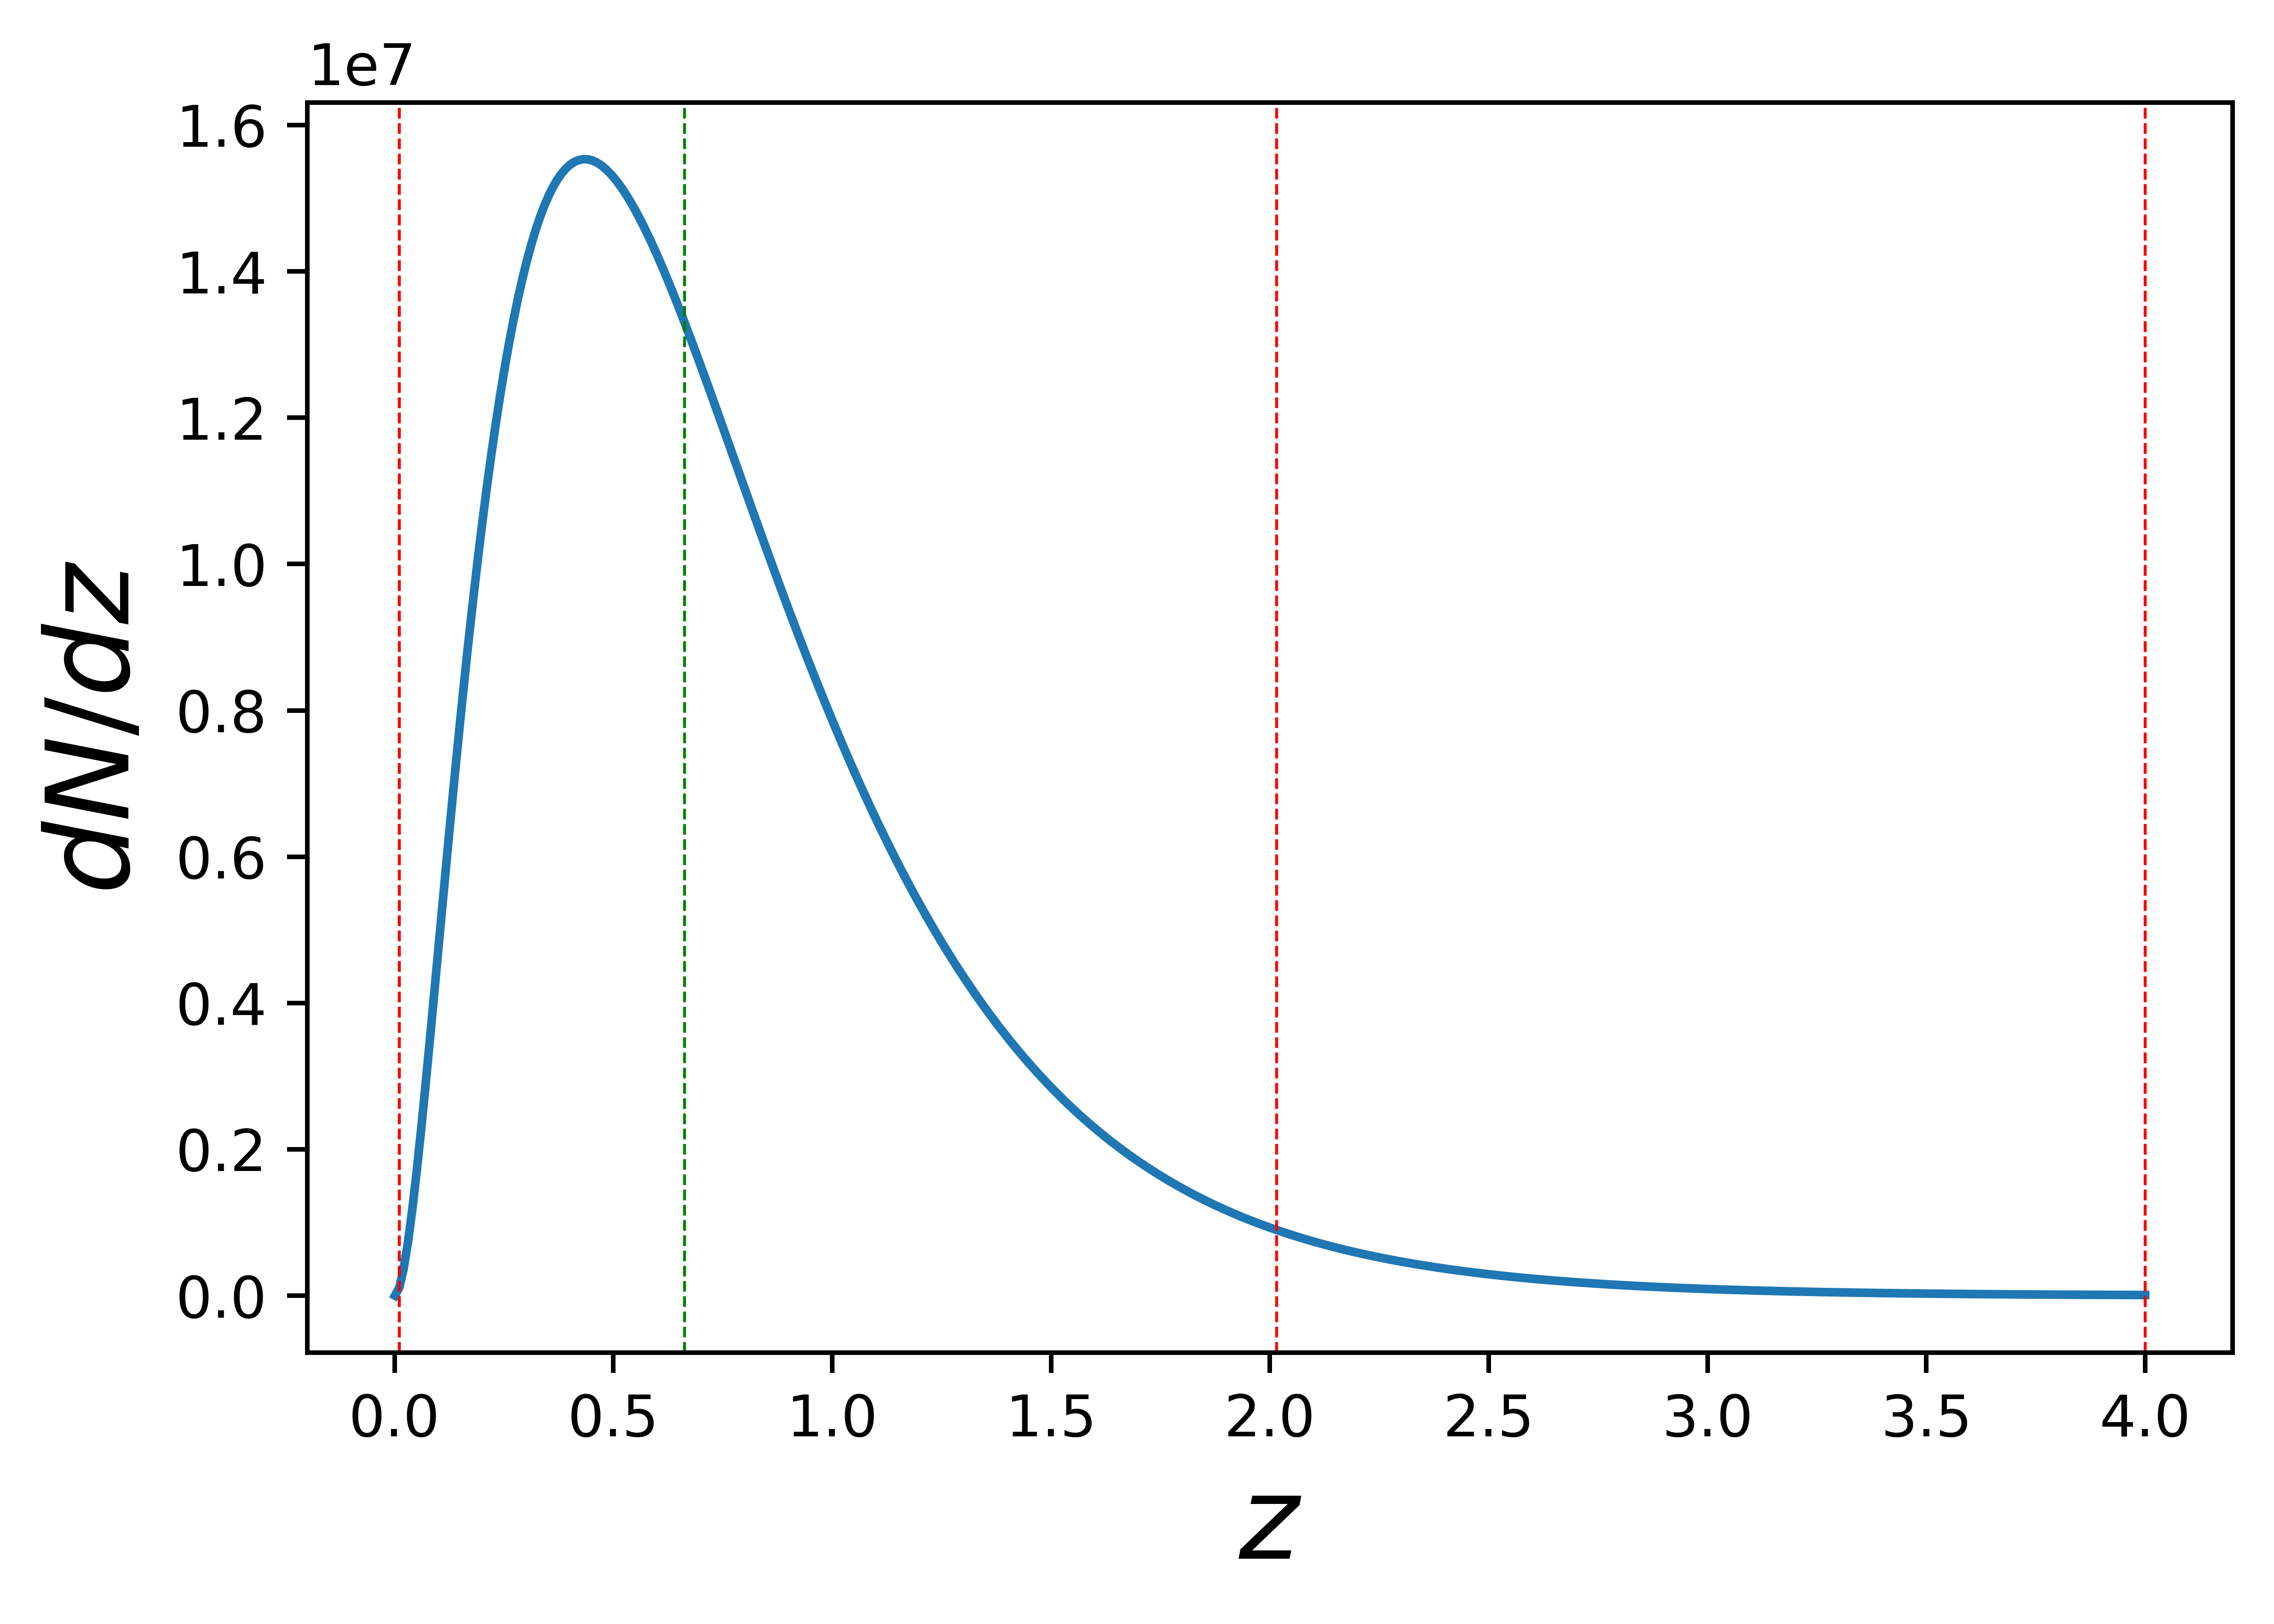

In [12]:
plt.plot(dndz[:,0], dndz[:,1])
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$dN/dz$',fontsize=20)
for x in redshifts["n_2"]:
    plt.axvline(x, linewidth=0.5, color="g", linestyle="--")
for x in redshifts["z_2"]:
    plt.axvline(x, linewidth=0.5, color="r", linestyle="--")
plt.show()

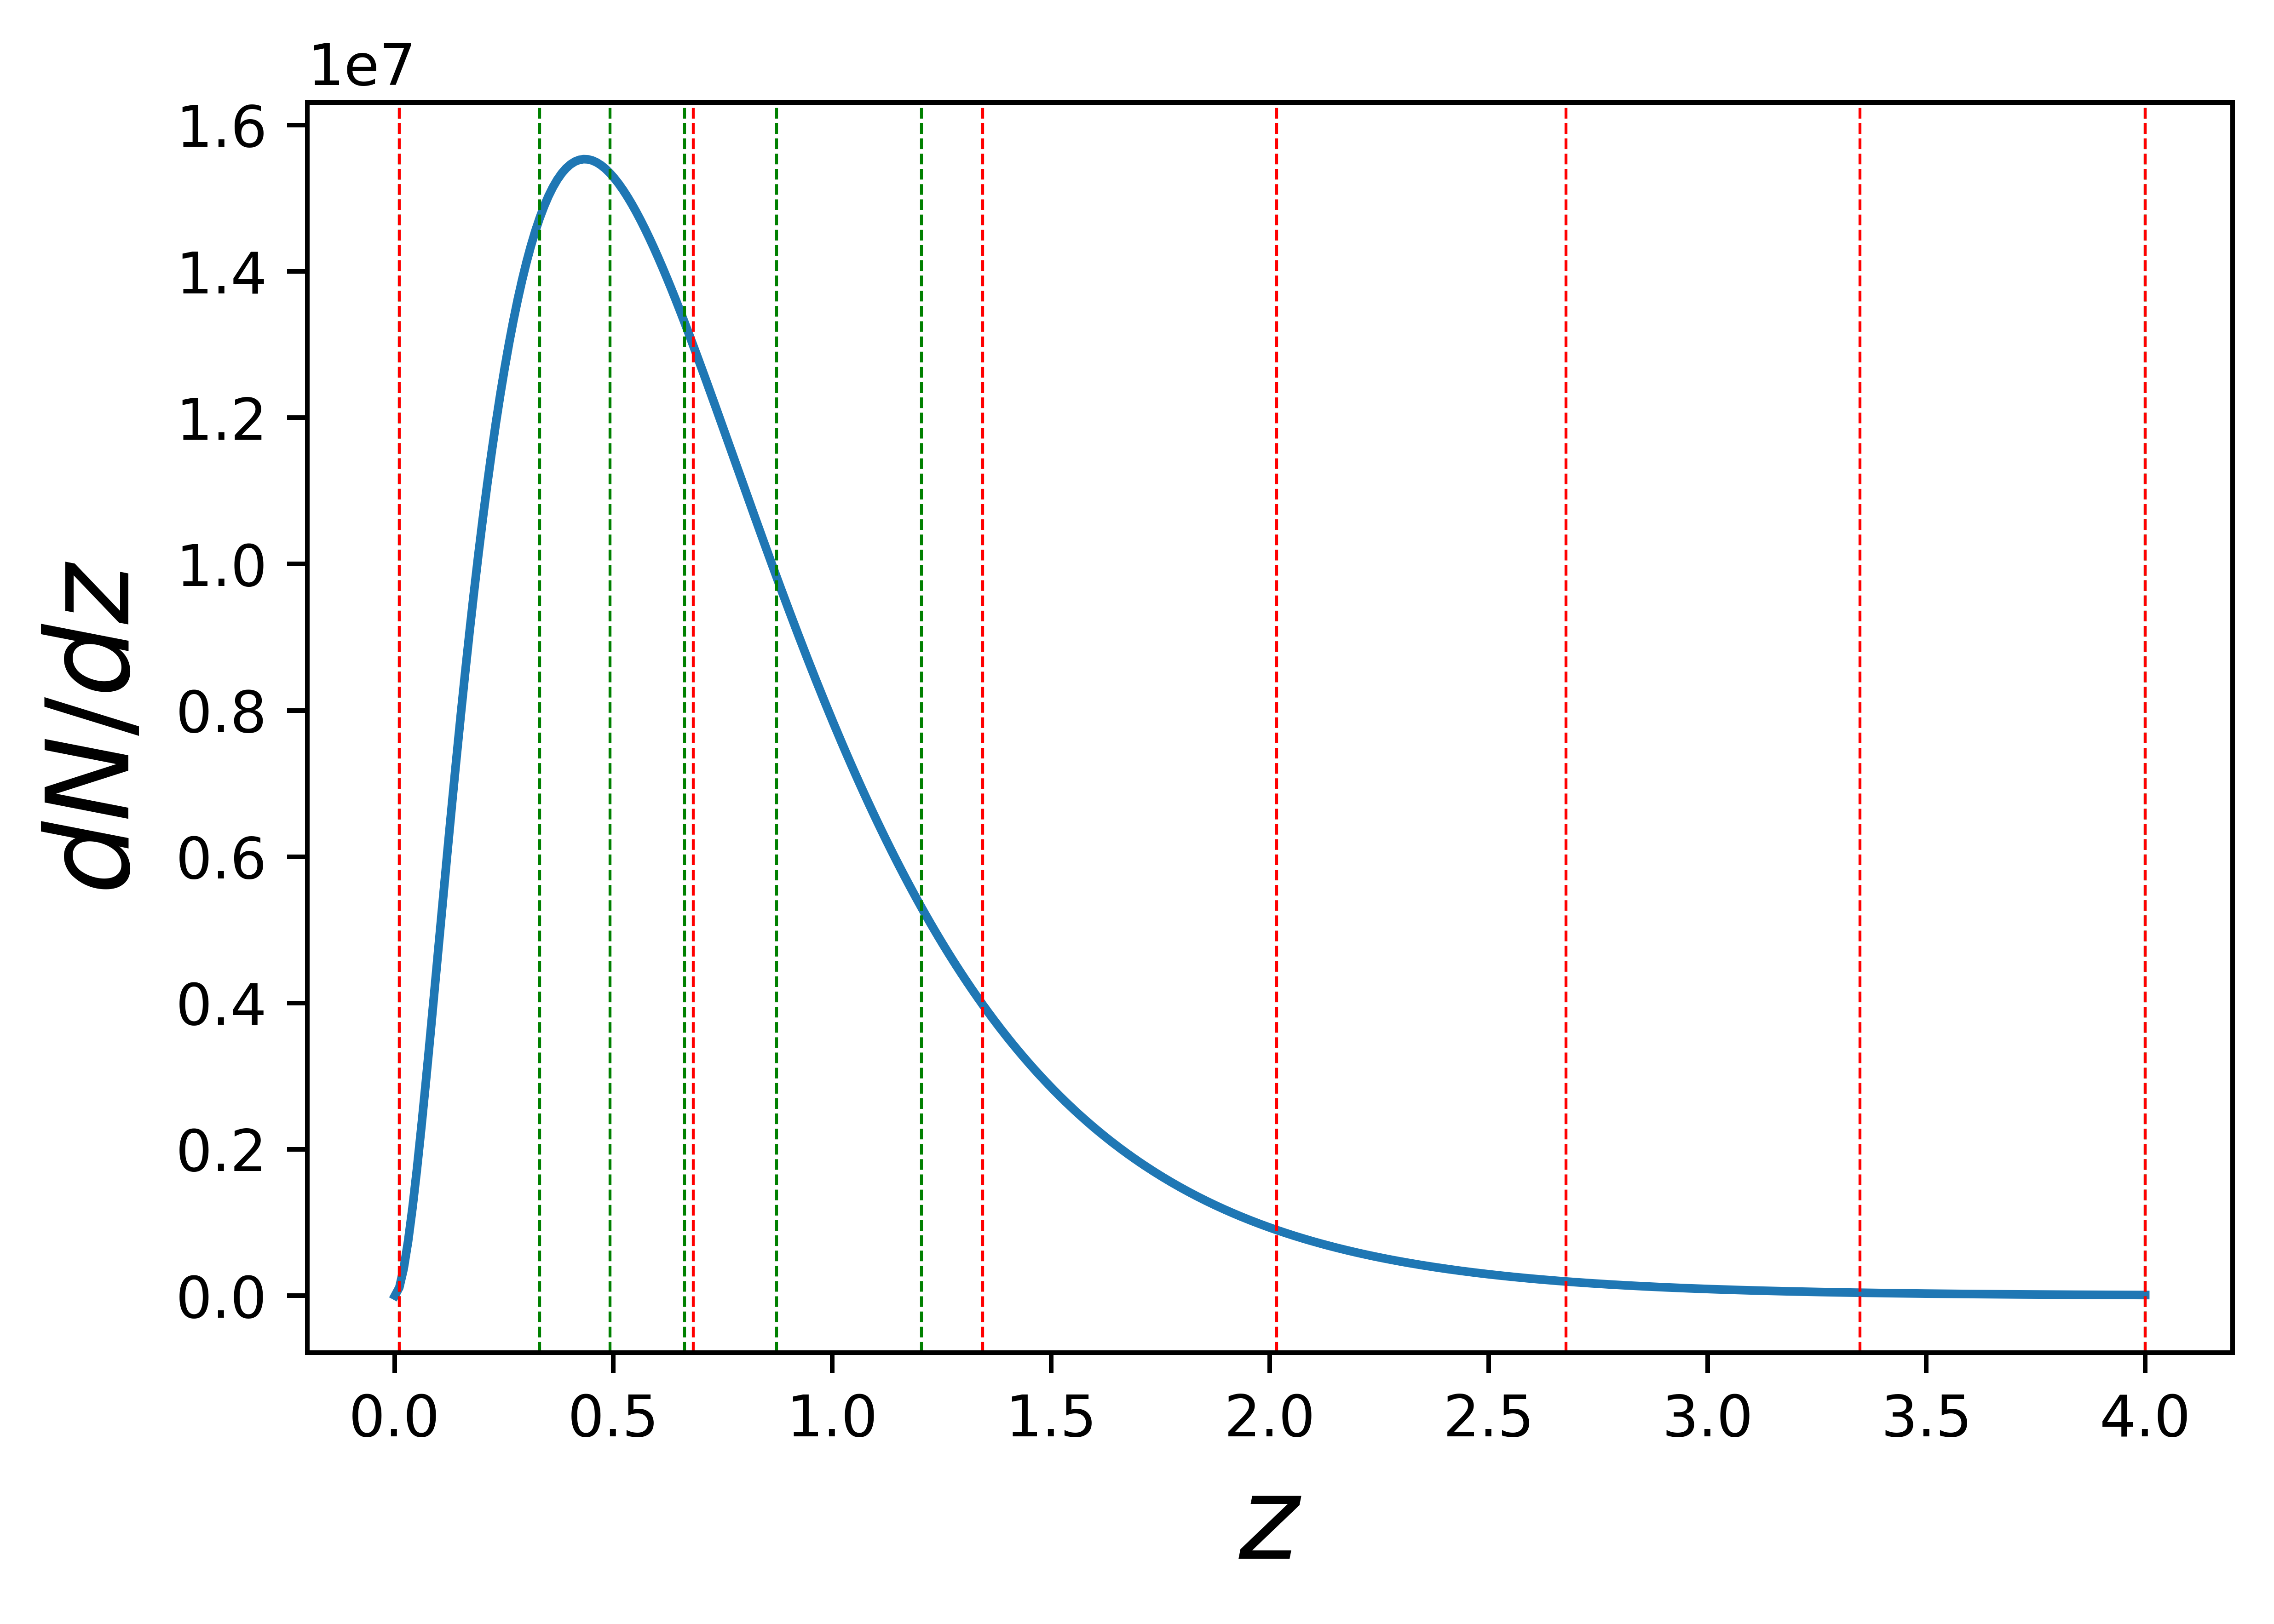

In [13]:
plt.plot(dndz[:,0], dndz[:,1])
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$dN/dz$',fontsize=20)
for x in redshifts["n_6"]:
    plt.axvline(x, linewidth=0.5, color="g", linestyle="--")
for x in redshifts["z_6"]:
    plt.axvline(x, linewidth=0.5, color="r", linestyle="--")
plt.show()

In [40]:
print(num_den(sliced_dndz["n_6"], numdenPerStr))

[19502046.15705112 19445513.89649938 19789444.5718278  19755195.94232621
 20000300.07481124 19972162.42654805]


In [41]:
numdenPerStr/6

19744110.511510633

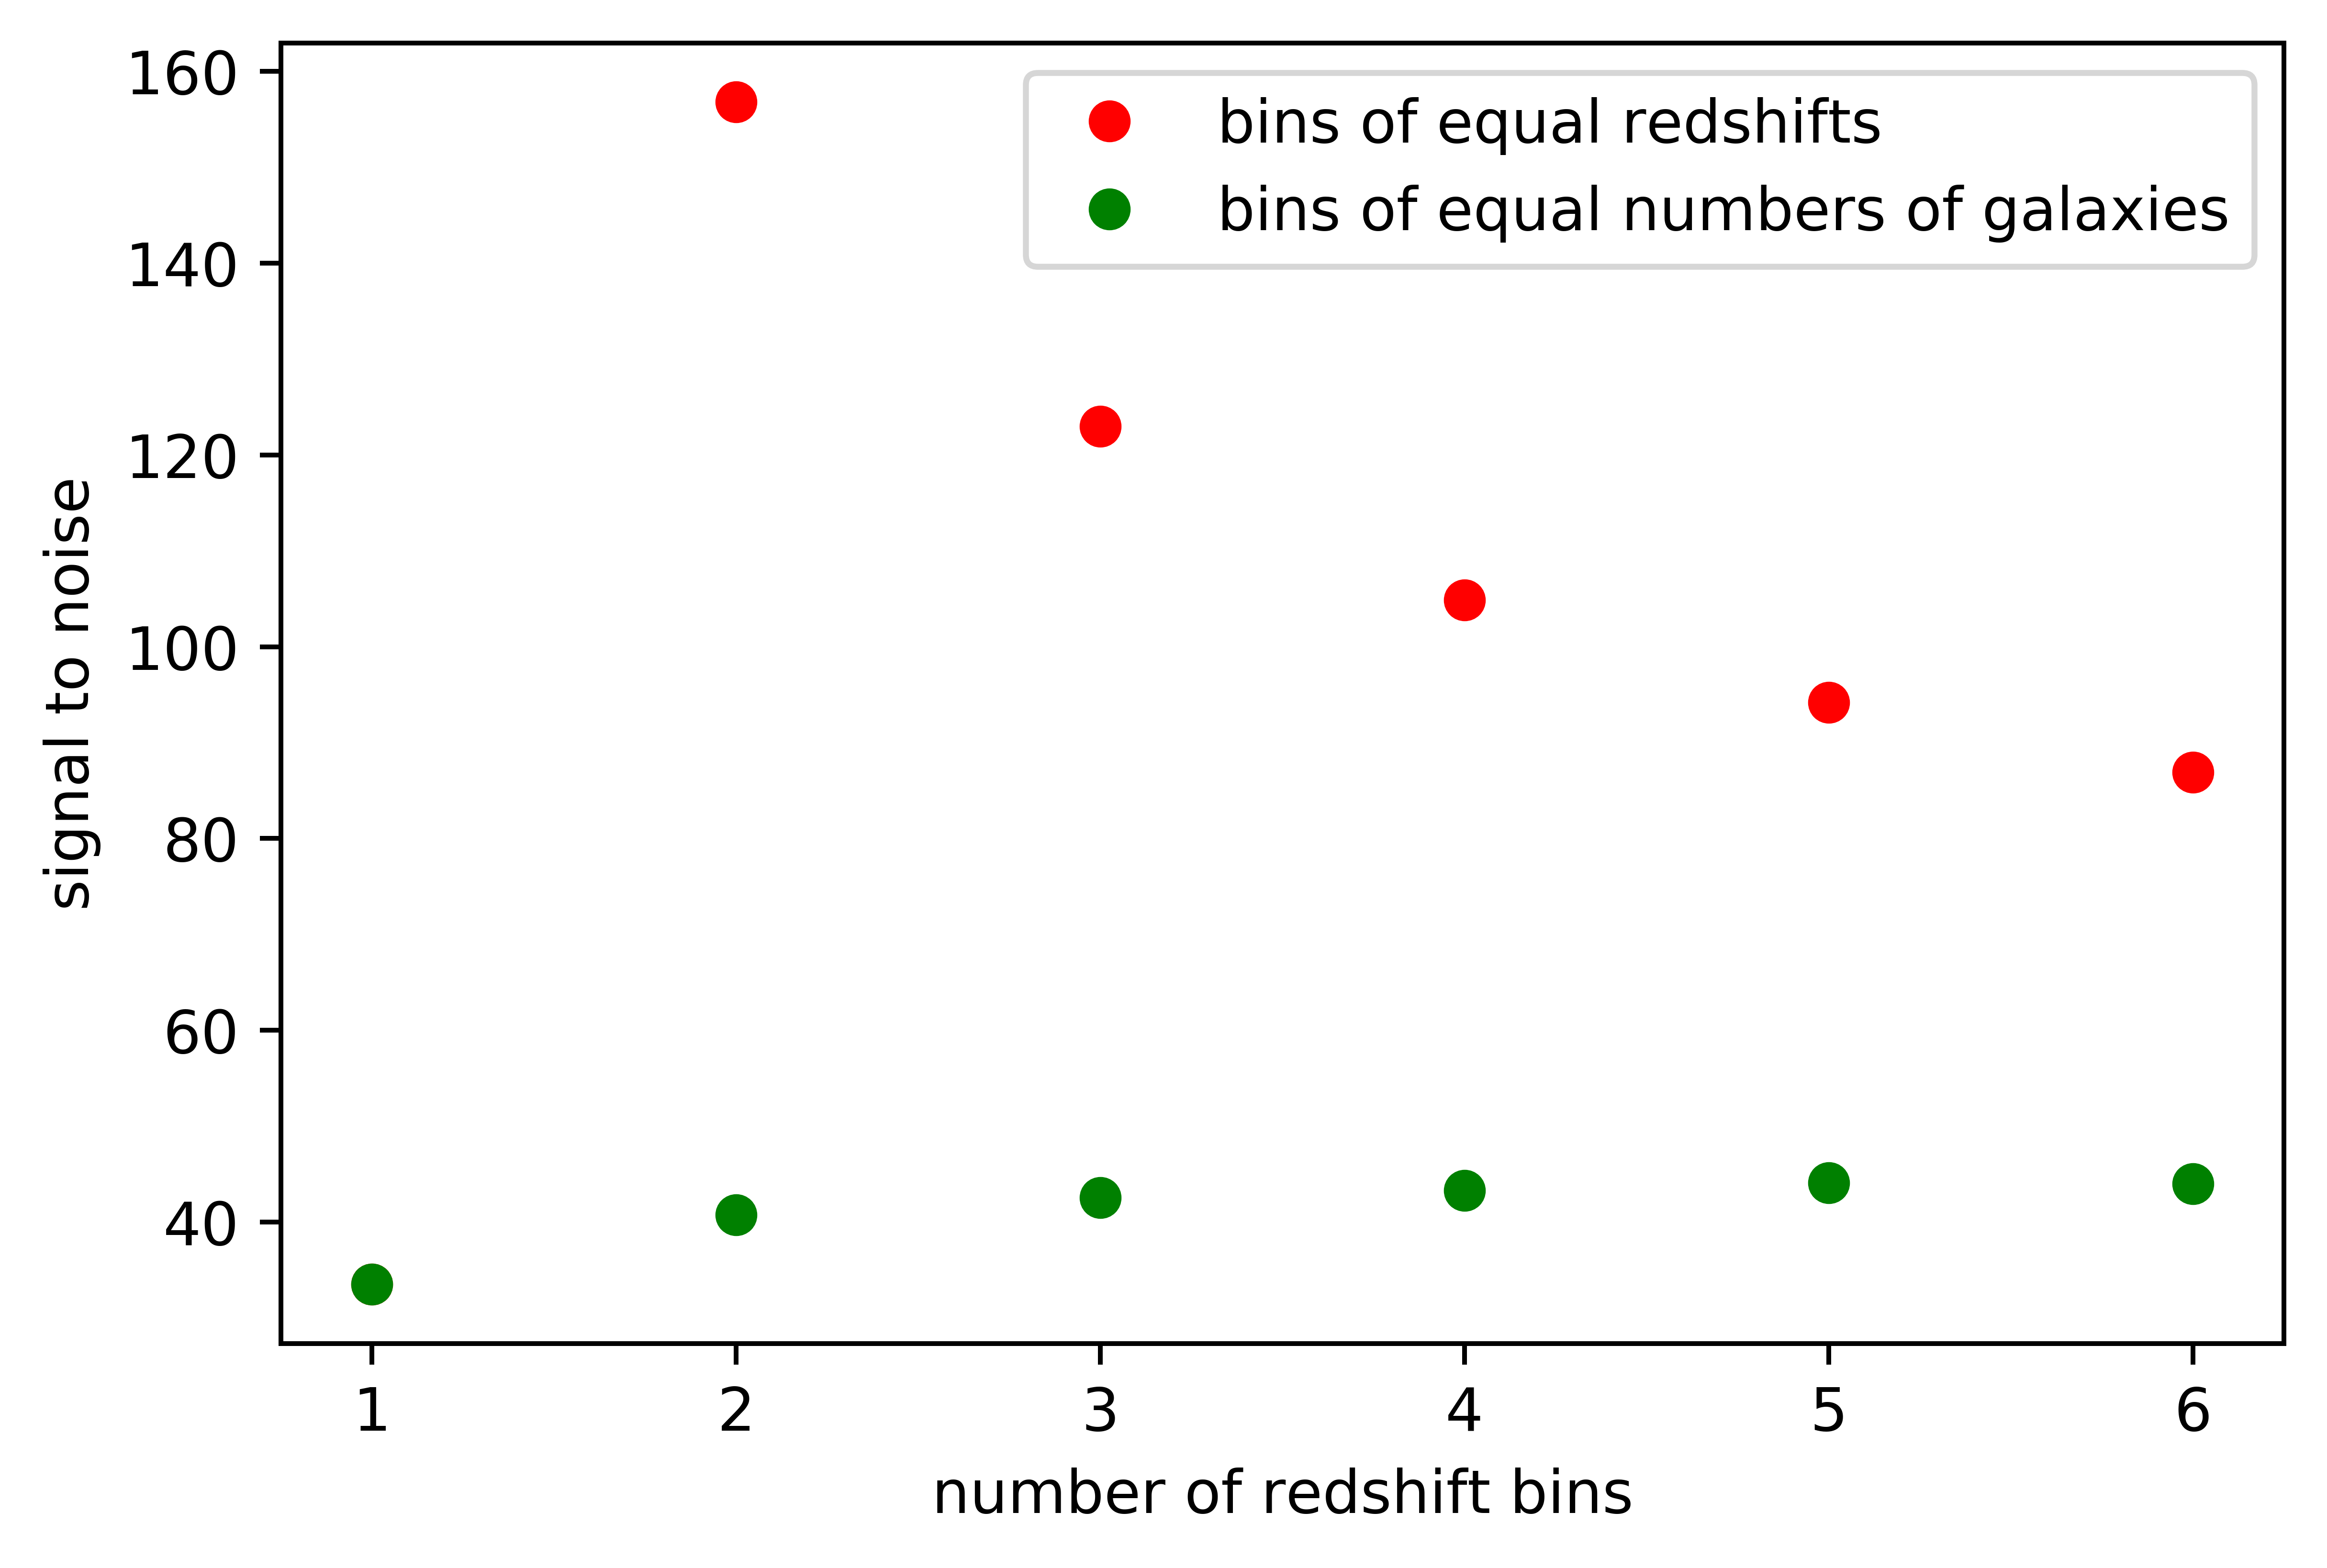

In [14]:
params = {'legend.fontsize': 10,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4, 5, 6], [stn["z_1"], stn["z_2"], stn["z_3"], stn["z_4"], stn["z_5"], stn["z_6"]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4, 5, 6], [stn["n_1"], stn["n_2"], stn["n_3"], stn["n_4"], stn["n_5"], stn["n_6"]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("number of redshift bins")
plt.ylabel("signal to noise")
plt.legend(loc="upper right")
plt.show() 

In [15]:
fisher = {}
for i in ["z", "n"]:
    for j in range(1,7):
        global dndz_sliced
        dndz_sliced = sliced_dndz["{0}_{1}".format(i, j)]
        fisher["{0}_{1}".format(i,j)] = fisher_matrix(covariance = cov["{0}_{1}".format(i, j)], dndz_sliced = sliced_dndz["{0}_{1}".format(i, j)])

In [16]:
fisher['n_5']

array([[33372.39019836, 24525.89308391,  -484.96769093, -1987.69667871,
        -2579.47006031,  -850.70656735,   251.89761685],
       [24525.89308391, 19337.37830511, -1390.95940593, -1594.04058344,
        -2157.21916205,  2287.69164138,  -674.76073016],
       [ -484.96769093, -1390.95940593,  1467.10873319,   209.738207  ,
          278.76345636, -3319.3066899 ,   977.79667105],
       [-1987.69667871, -1594.04058344,   209.738207  ,   144.84093604,
          190.44813167,  -356.70105266,   104.91554743],
       [-2579.47006031, -2157.21916205,   278.76345636,   190.44813167,
          266.80334383,  -534.78187111,   157.47989136],
       [ -850.70656735,  2287.69164138, -3319.3066899 ,  -356.70105266,
         -534.78187111,  8710.79250595, -2568.87230509],
       [  251.89761685,  -674.76073016,   977.79667105,   104.91554743,
          157.47989136, -2568.87230509,   757.59492997]])

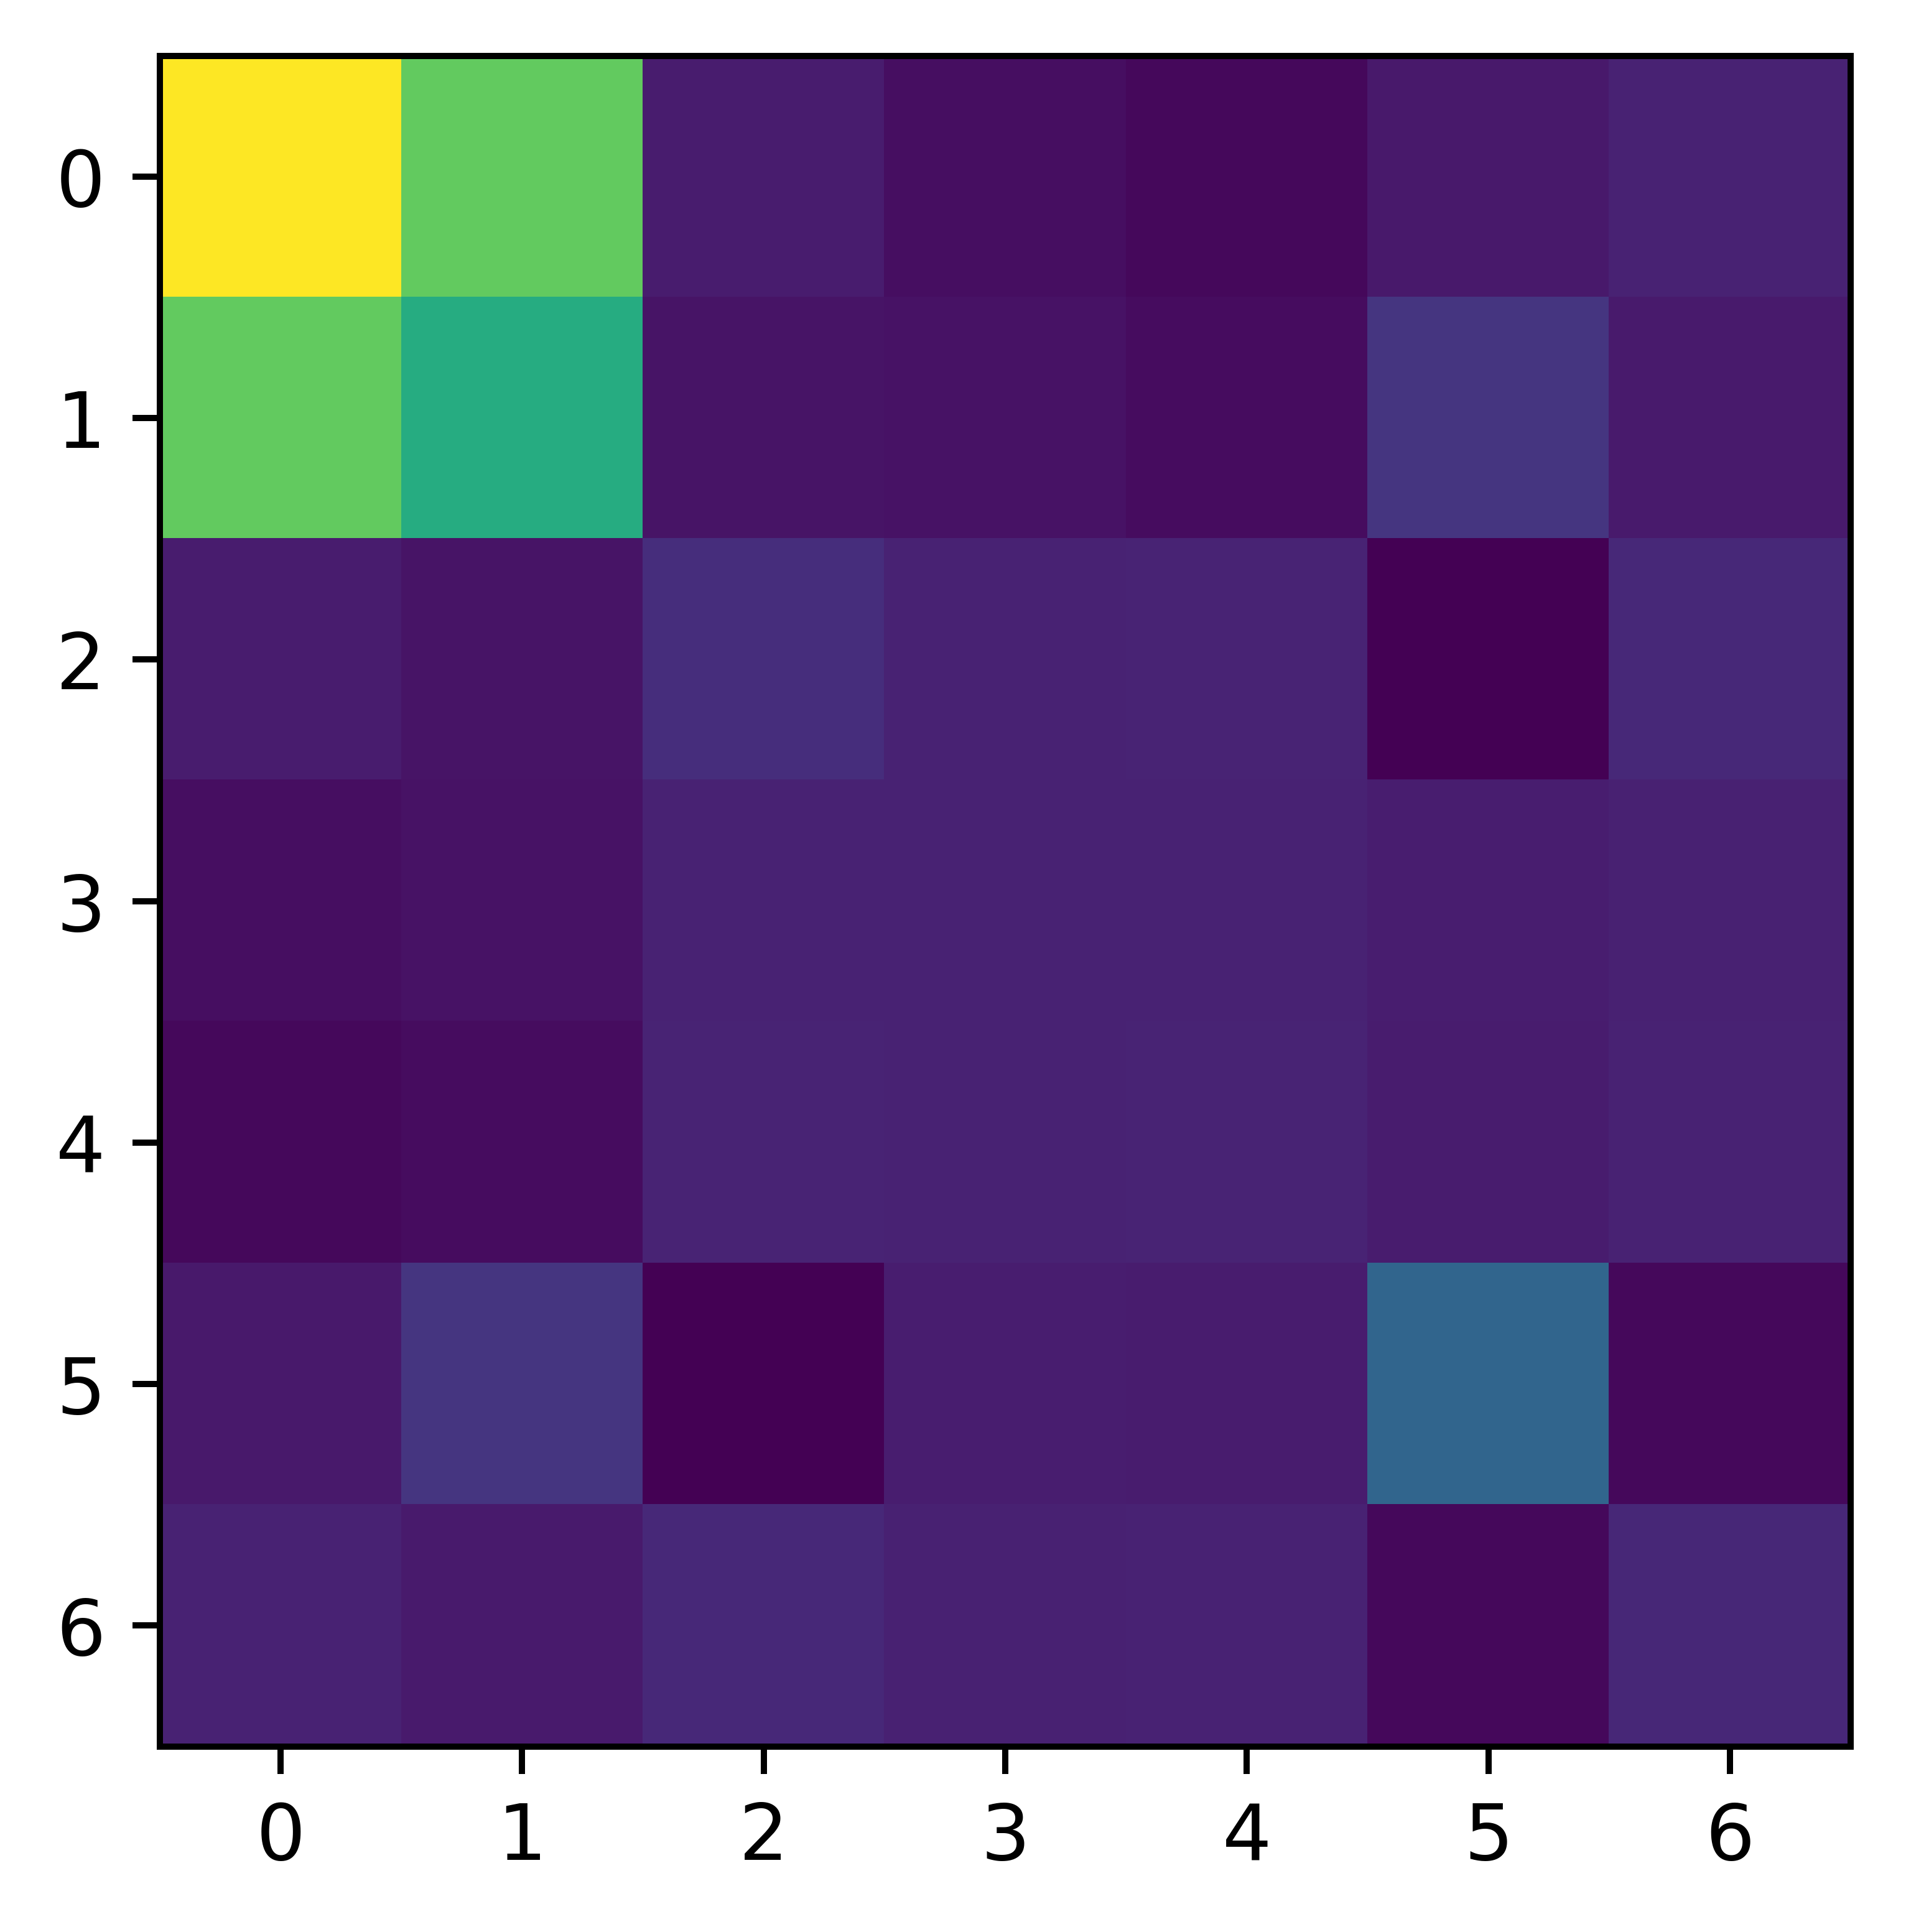

In [17]:
plt.imshow(fisher['n_5'])

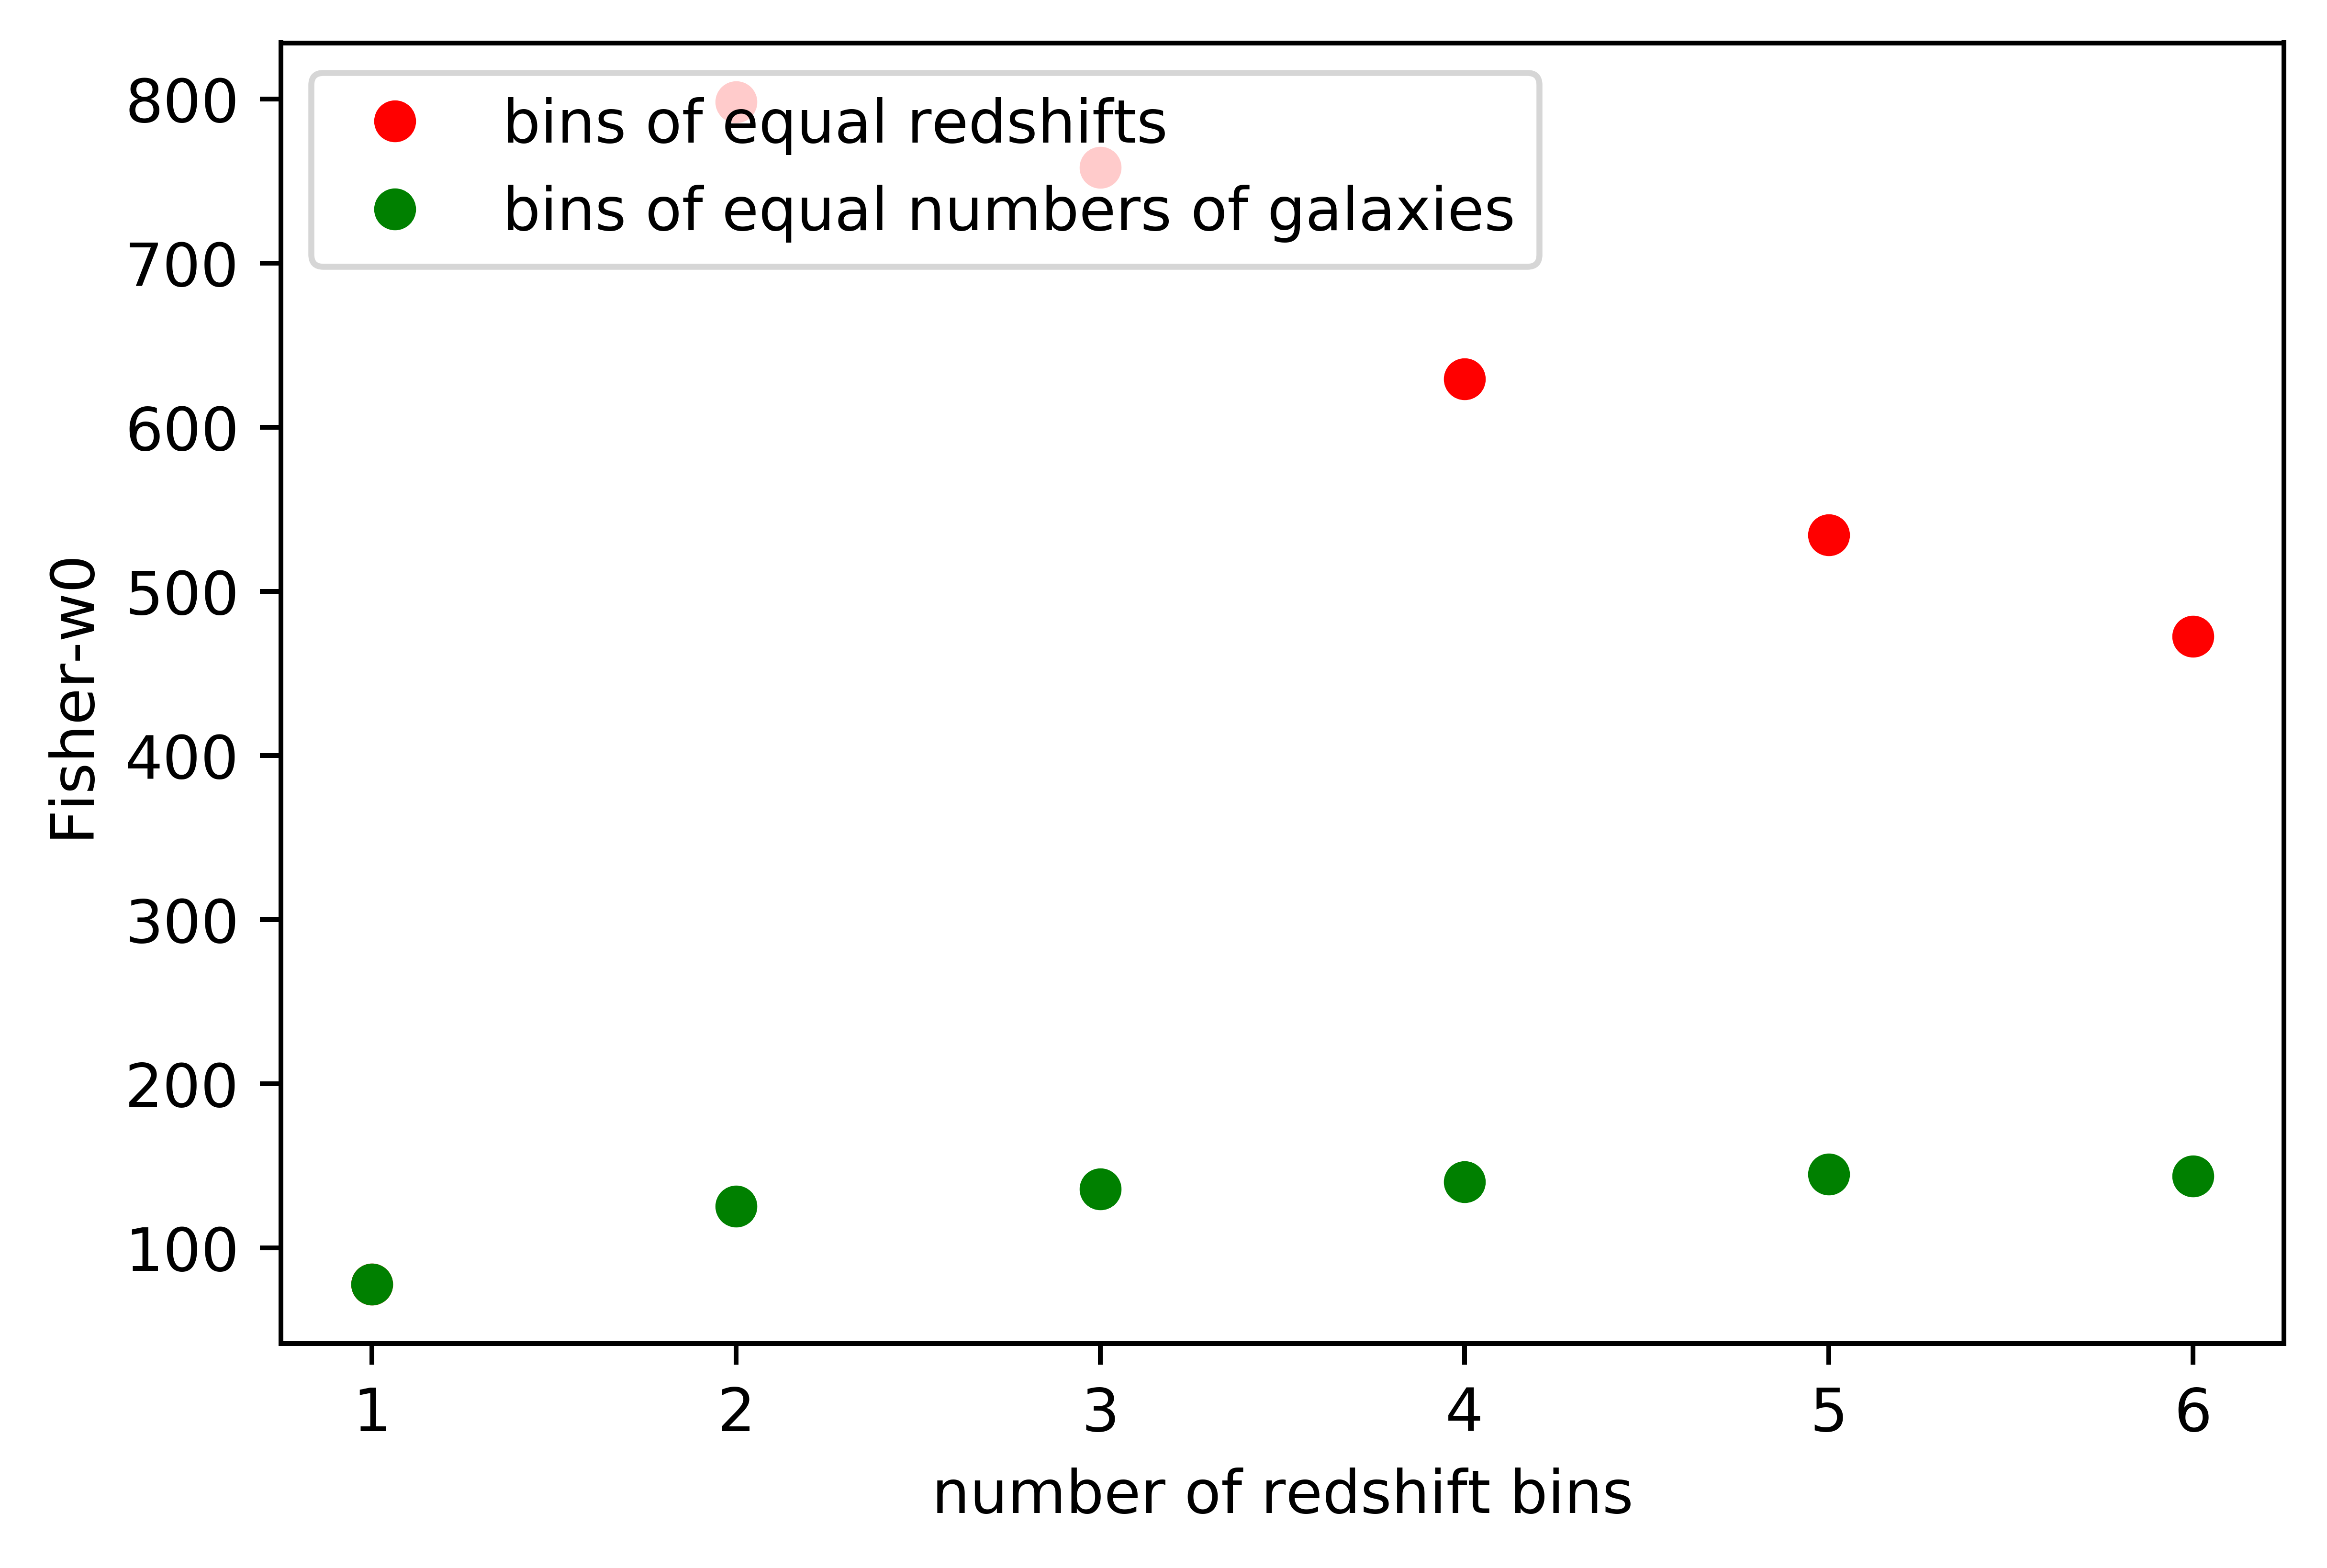

In [18]:
params = {'legend.fontsize': 10,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4, 5, 6], [fisher["z_1"][3,3], fisher["z_2"][3,3], fisher["z_3"][3,3], fisher["z_4"][3,3], fisher["z_5"][3,3], fisher["z_6"][3,3]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4, 5, 6], [fisher["n_1"][3,3], fisher["n_2"][3,3], fisher["n_3"][3,3], fisher["n_4"][3,3], fisher["n_5"][3,3], fisher["n_6"][3,3]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("number of redshift bins")
plt.ylabel("Fisher-w0")
plt.legend(loc="upper left")
plt.show() 

In [19]:
#try a symmetric distribution for galaxy-redshift distribution
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [20]:
dndz_s = np.zeros([400,2])
dndz_s[:, 0] = np.linspace(0.001, 4, 400)
dndz_s[:, 1] = gaussian(dndz_s[:, 0], 2, 0.5)

In [30]:
cl_s = {} 
cov_s = {}
redshifts_s = {}
sliced_dndz_s = {}

for n in range(1,5):
    for btype in ["z", "n"]:
        cov_s["{0}_{1}".format(btype, n)], cl_s["{0}_{1}".format(btype, n)], redshifts_s["{0}_{1}".format(btype, n)], sliced_dndz_s["{0}_{1}".format(btype, n)] = getDataArray(n_bins=n, bin_type=btype, cosmo=cosmo, dndz=dndz_s, ell=ell, numdenPerStr = numdenPerStr, fsky=0.4)

In [23]:
stn_s = {}
for i in ["z", "n"]:
    for j in range(1,5):
        stn_s["{0}_{1}".format(i,j)] = SignalToNoise(bins_in_z=j, binl=binl, cl = cl_s["{0}_{1}".format(i, j)], cov = cov_s["{0}_{1}".format(i, j)], ell=ell)

In [24]:
fisher_s = {}
for i in ["z", "n"]:
    for j in range(1,5):
        global dndz_sliced
        dndz_sliced = sliced_dndz_s["{0}_{1}".format(i, j)]
        fisher_s["{0}_{1}".format(i,j)] = fisher_matrix(covariance = cov_s["{0}_{1}".format(i, j)], dndz_sliced = sliced_dndz_s["{0}_{1}".format(i, j)])

In [25]:
print(sliced_dndz_s['n_4']['bin_3'][-1])
print(sliced_dndz_s['z_4']['bin_3'][-1])

[4.00000000e+00 3.35462628e-04]
[4.00000000e+00 3.35462628e-04]


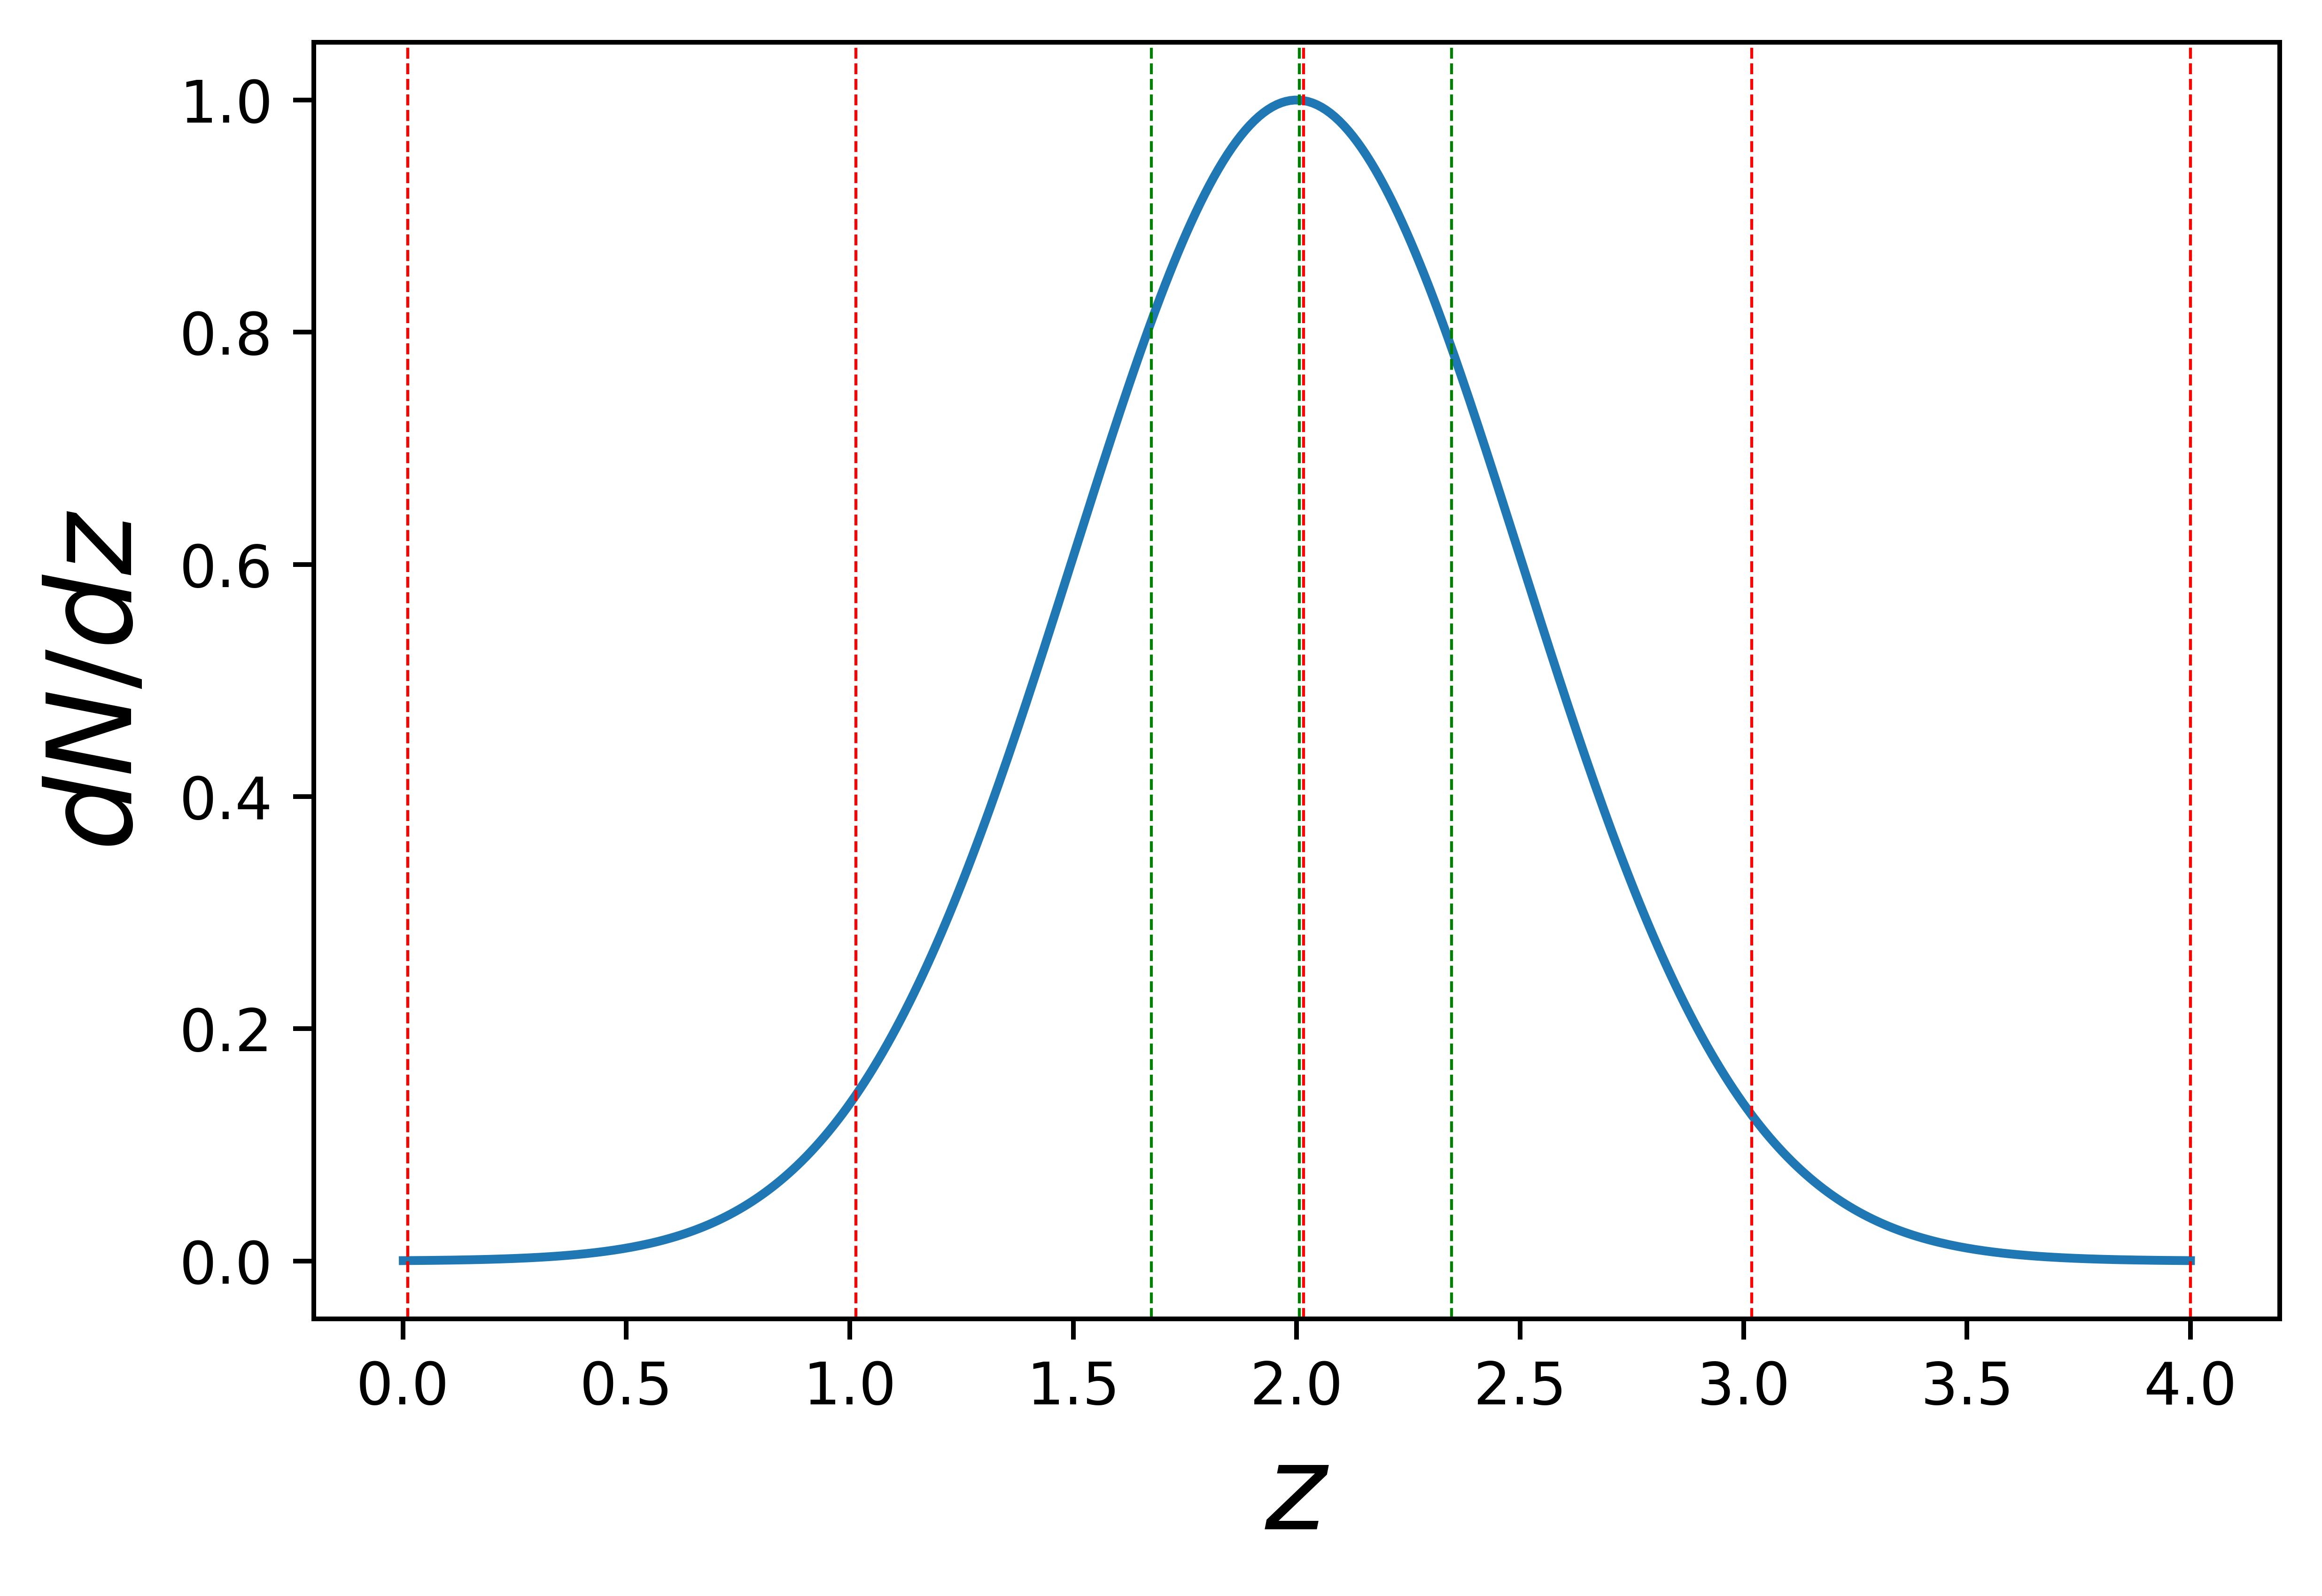

In [31]:
plt.plot(dndz_s[:,0], dndz_s[:,1])
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$dN/dz$',fontsize=20)
for x in redshifts_s["n_4"]:
    plt.axvline(x, linewidth=0.5, color="g", linestyle="--")
for x in redshifts_s["z_4"]:
    plt.axvline(x, linewidth=0.5, color="r", linestyle="--")
plt.show()

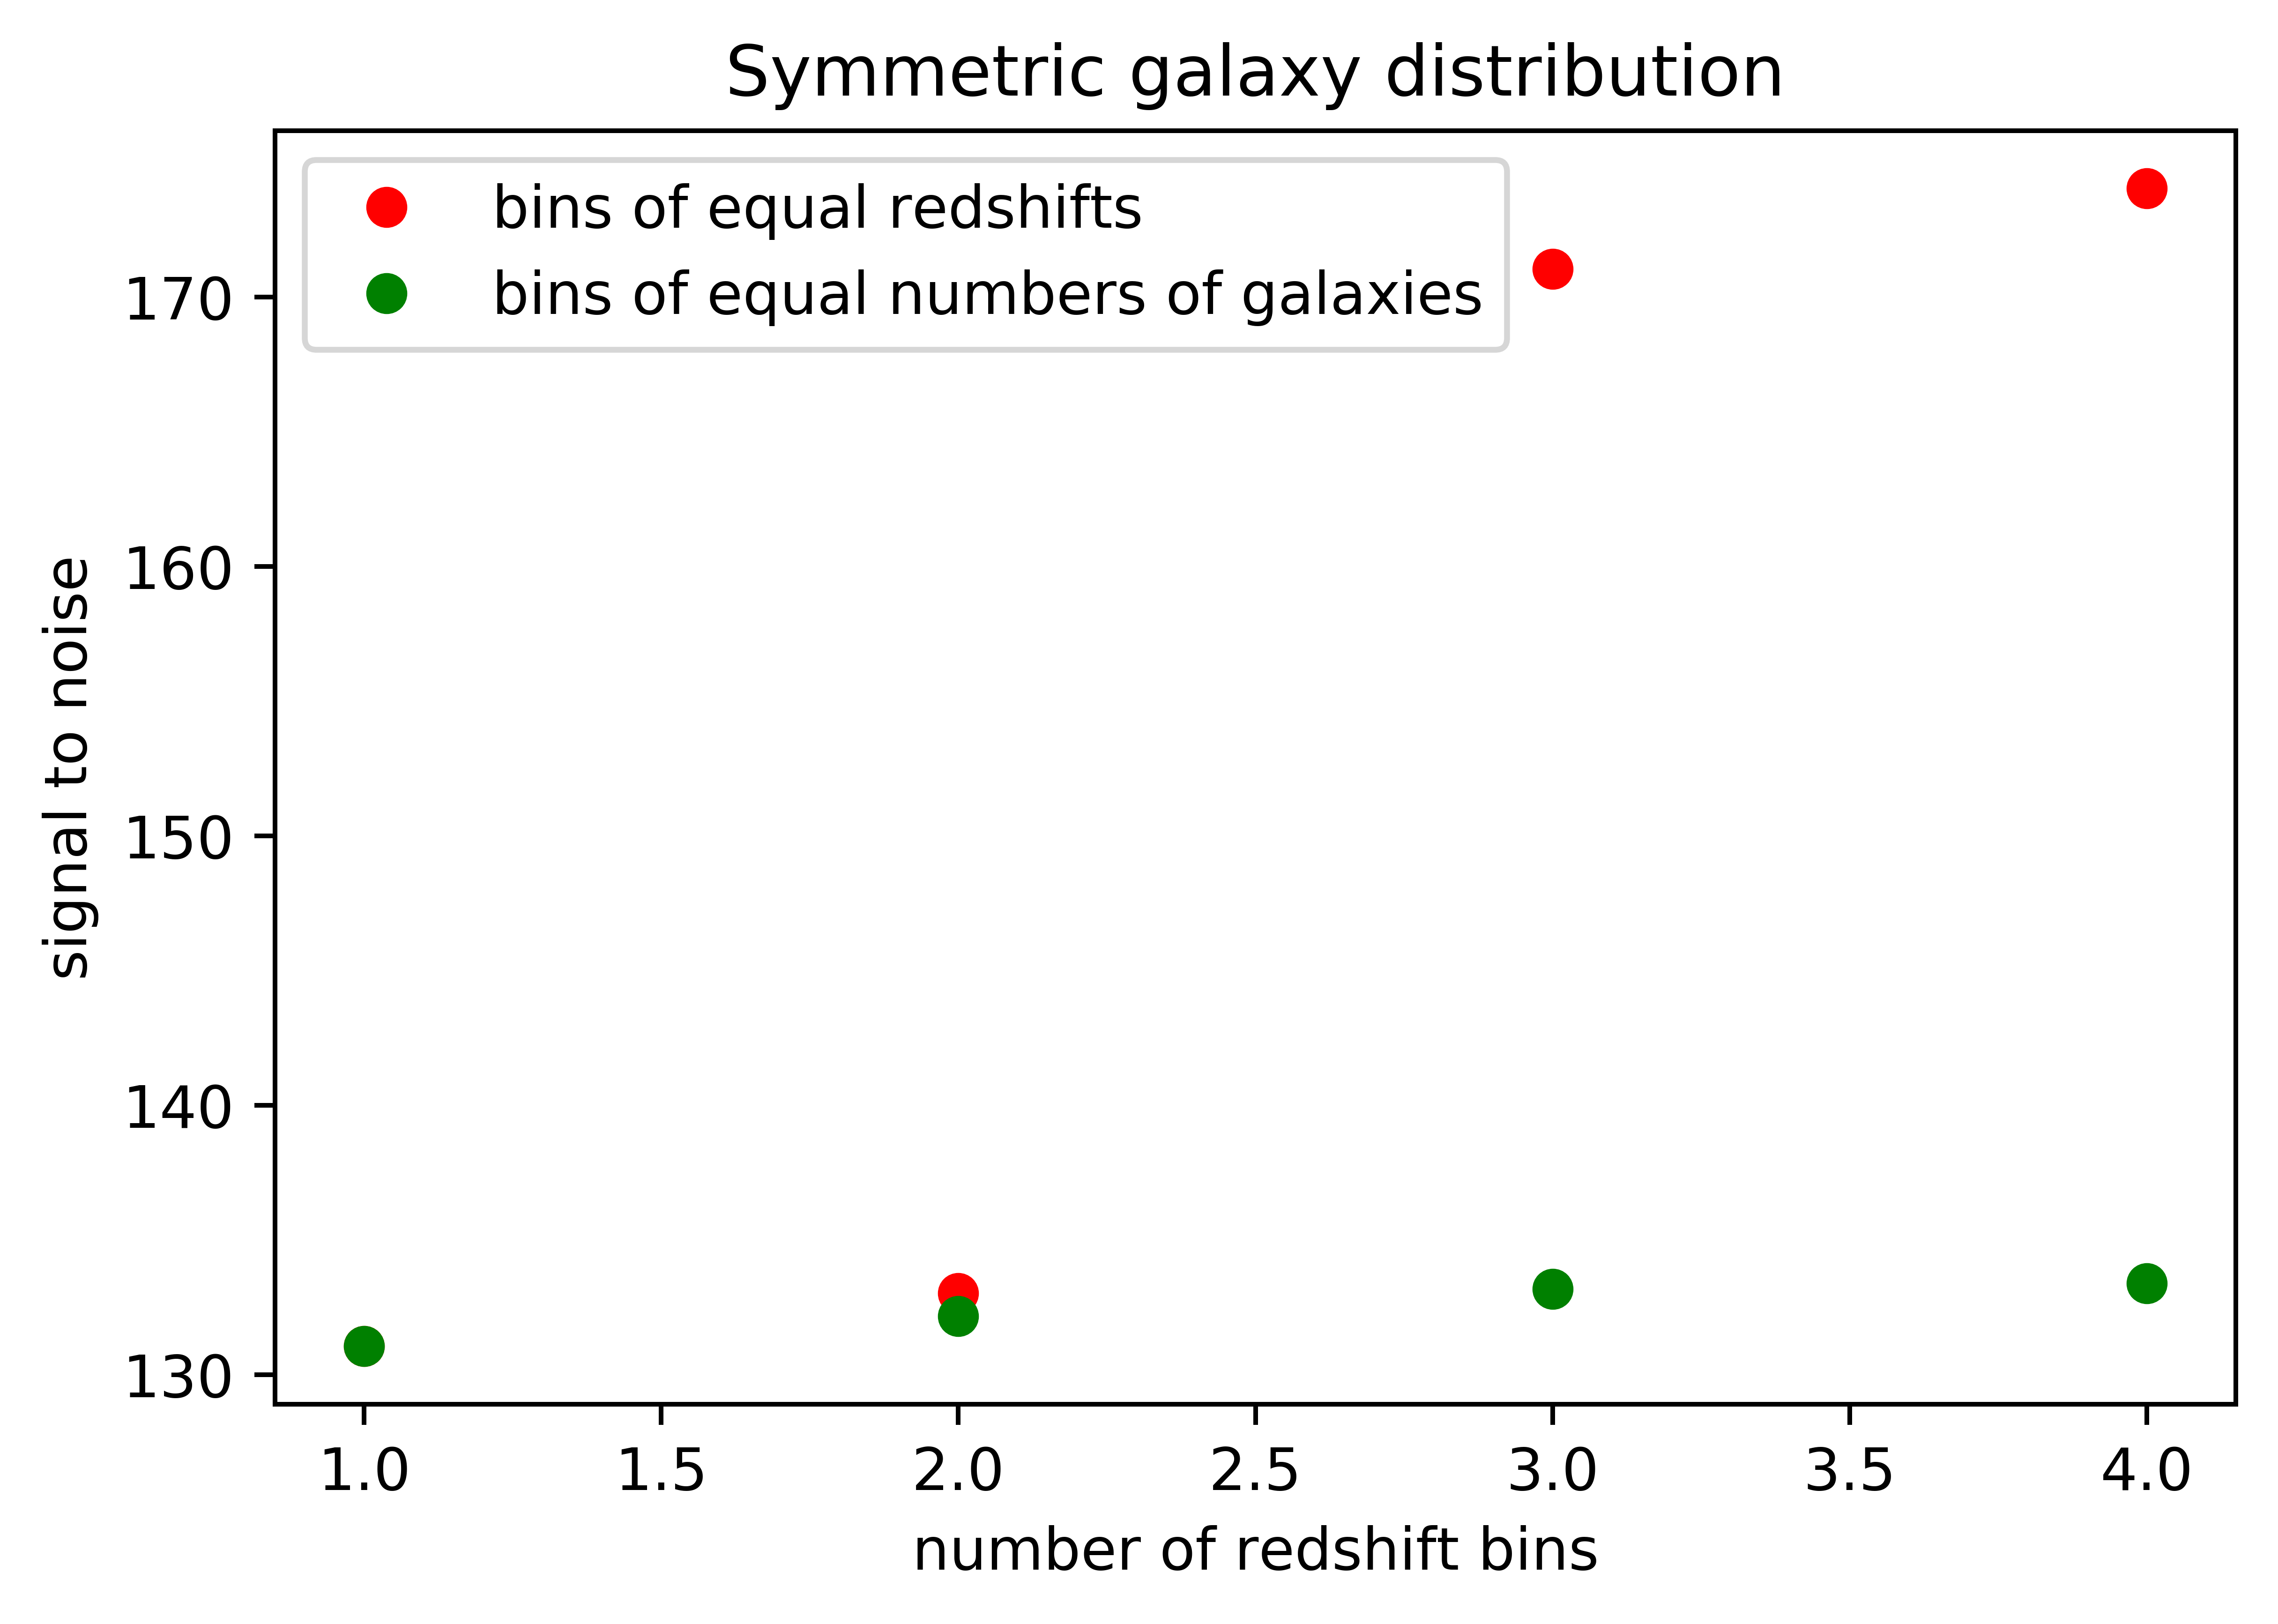

In [27]:
params = {'legend.fontsize': 10,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4], [stn_s["z_1"], stn_s["z_2"], stn_s["z_3"], stn_s["z_4"]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4], [stn_s["n_1"], stn_s["n_2"], stn_s["n_3"], stn_s["n_4"]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("number of redshift bins")
plt.ylabel("signal to noise")
plt.legend(loc="upper left")
plt.title('Symmetric galaxy distribution')
plt.show() 

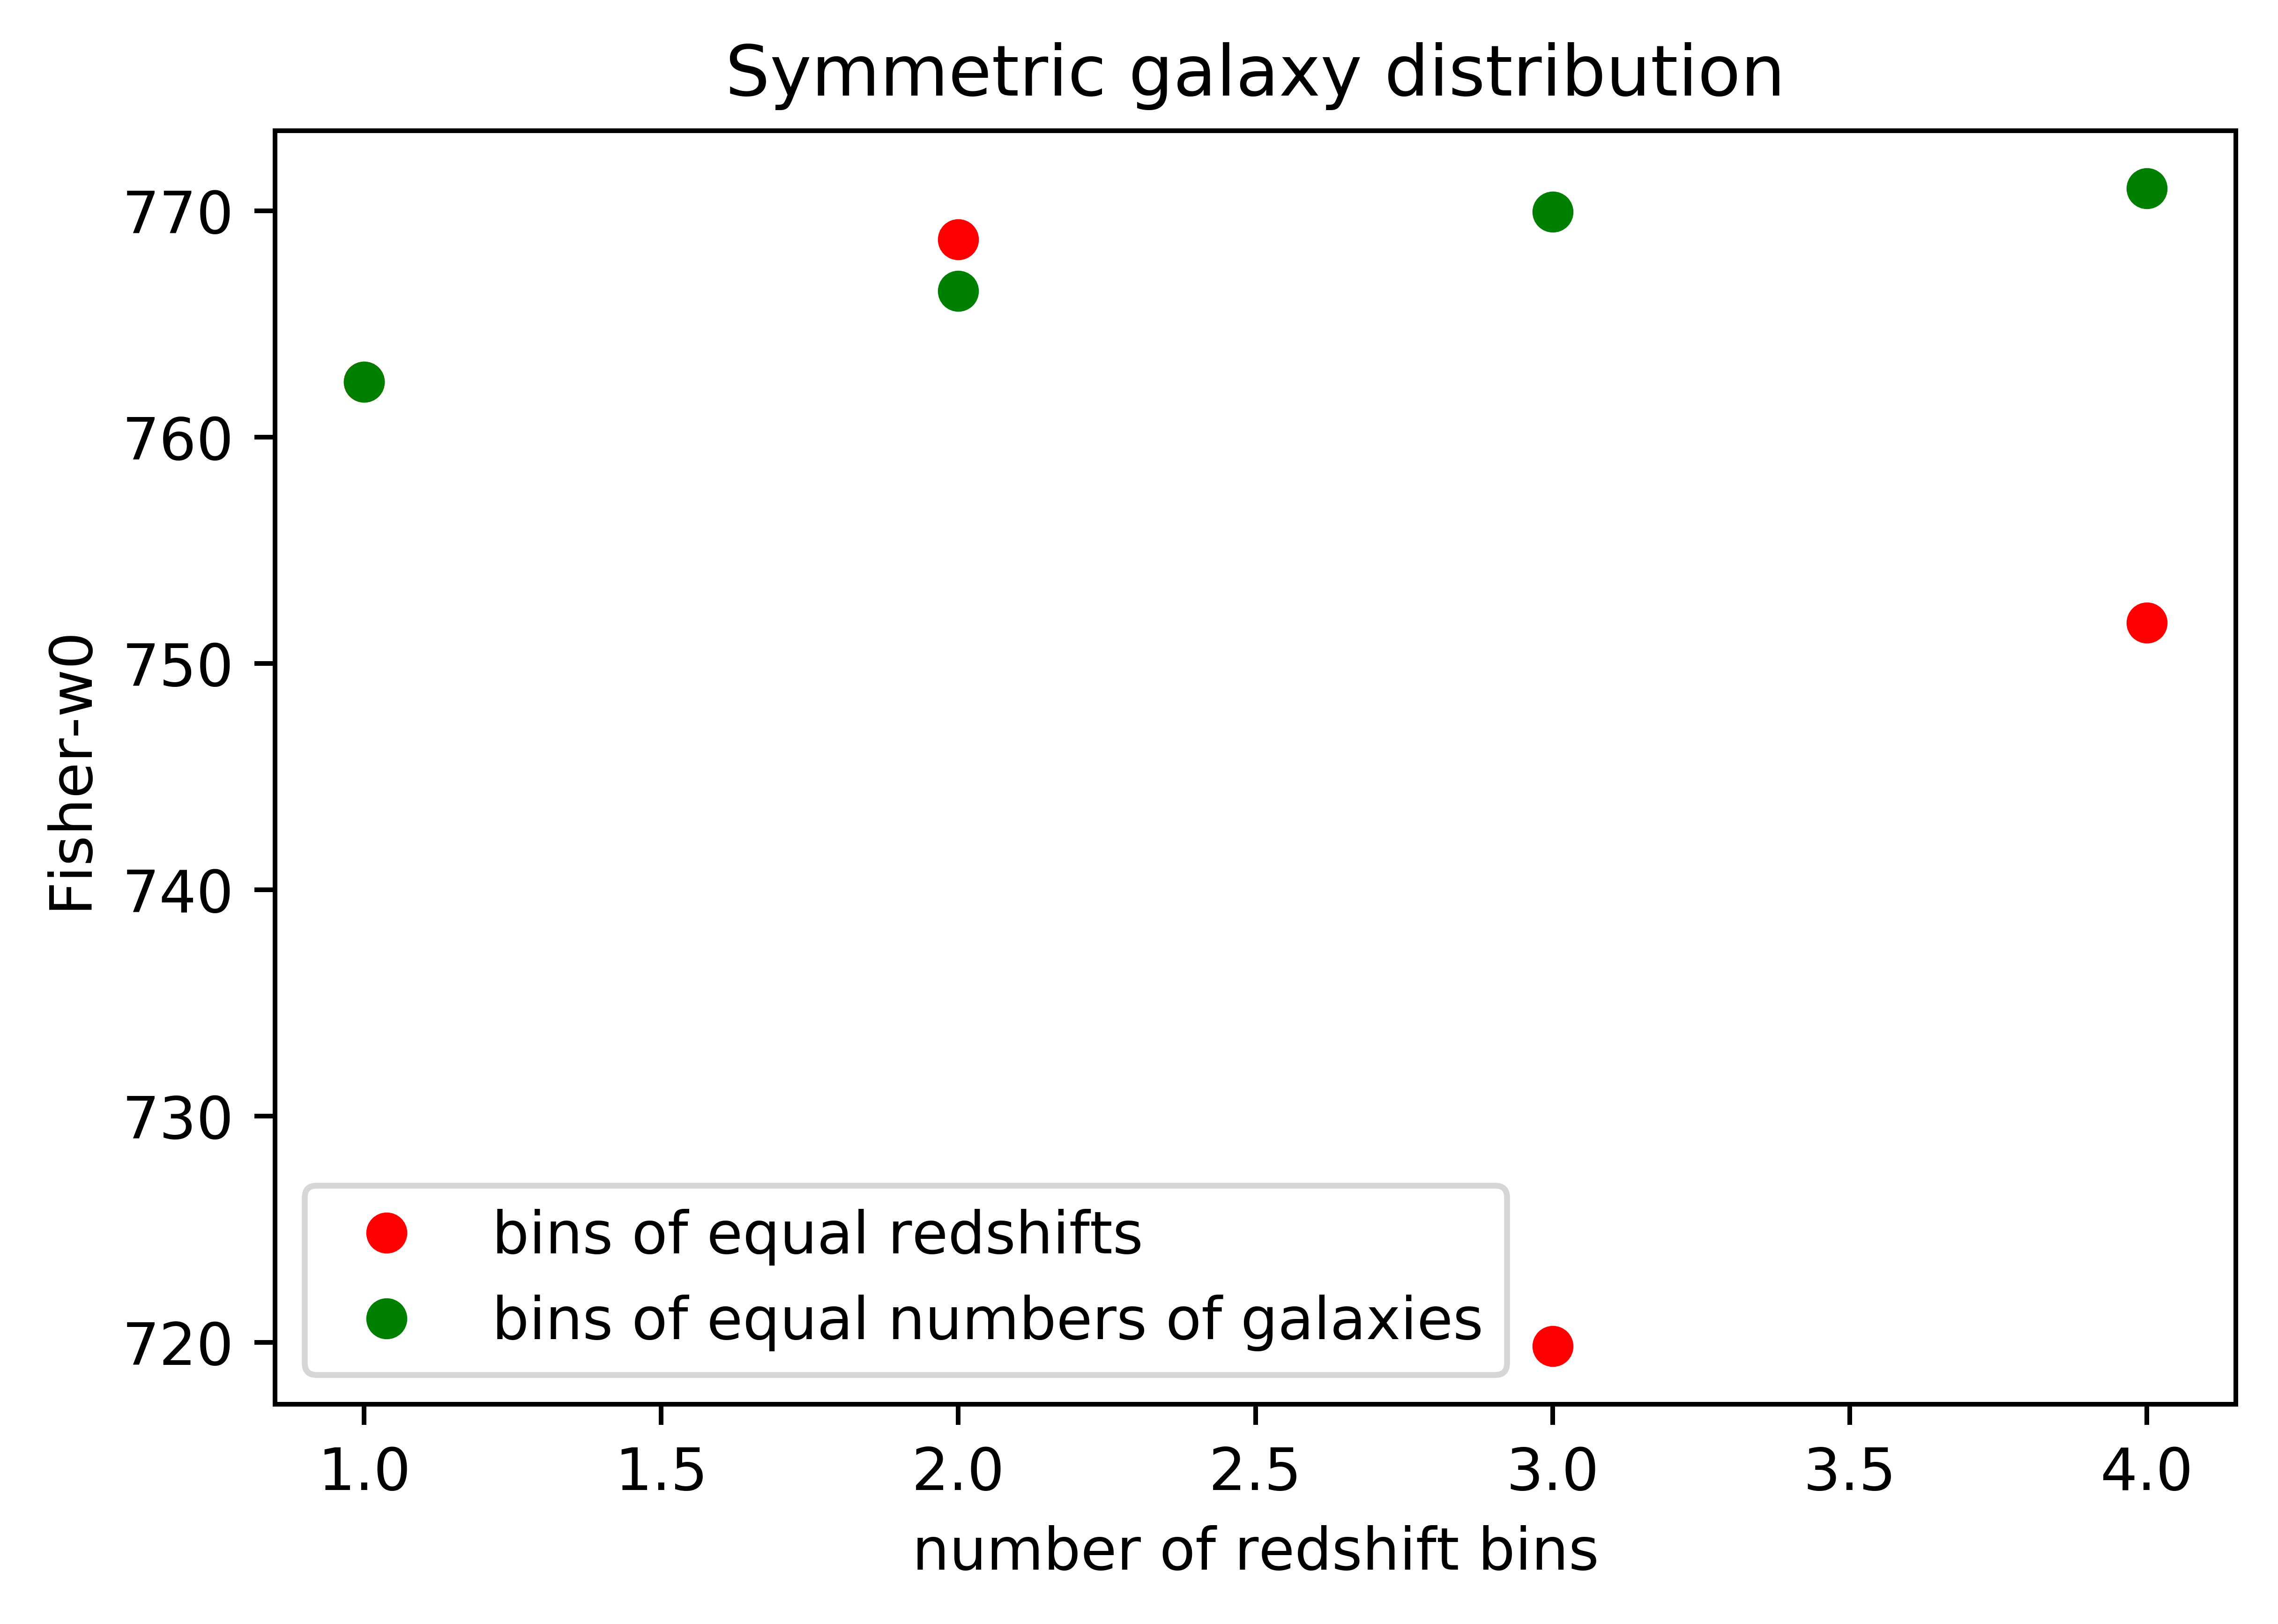

In [33]:
params = {'legend.fontsize': 10,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4], [fisher_s["z_1"][3,3], fisher_s["z_2"][3,3], fisher_s["z_3"][3,3], fisher_s["z_4"][3,3]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4], [fisher_s["n_1"][3,3], fisher_s["n_2"][3,3], fisher_s["n_3"][3,3], fisher_s["n_4"][3,3]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("number of redshift bins")
plt.ylabel("Fisher-w0")
plt.legend(loc="lower left")
plt.title('Symmetric galaxy distribution')
plt.show() 

In [32]:
#try a flat distribution
dndz_f = np.zeros([400,2])
dndz_f[:, 0] = np.linspace(0.001, 4, 400)
dndz_f[:, 1] = np.ones(400)

In [34]:
cl_f = {} 
cov_f = {}
redshifts_f = {}
sliced_dndz_f = {}

for n in range(1,5):
    for btype in ["z", "n"]:
        cov_f["{0}_{1}".format(btype, n)], cl_f["{0}_{1}".format(btype, n)], redshifts_f["{0}_{1}".format(btype, n)], sliced_dndz_f["{0}_{1}".format(btype, n)] = getDataArray(n_bins=n, bin_type=btype, cosmo=cosmo, dndz=dndz_f, ell=ell, numdenPerStr = numdenPerStr, fsky=0.4)

In [35]:
stn_f = {}
for i in ["z", "n"]:
    for j in range(1,5):
        stn_f["{0}_{1}".format(i,j)] = SignalToNoise(bins_in_z=j, binl=binl, cl = cl_f["{0}_{1}".format(i, j)], cov = cov_f["{0}_{1}".format(i, j)], ell=ell)

In [36]:
fisher_f = {}
for i in ["z", "n"]:
    for j in range(1,5):
        global dndz_sliced
        dndz_sliced = sliced_dndz_f["{0}_{1}".format(i, j)]
        fisher_f["{0}_{1}".format(i,j)] = fisher_matrix(covariance = cov_f["{0}_{1}".format(i, j)], dndz_sliced = sliced_dndz_f["{0}_{1}".format(i, j)])

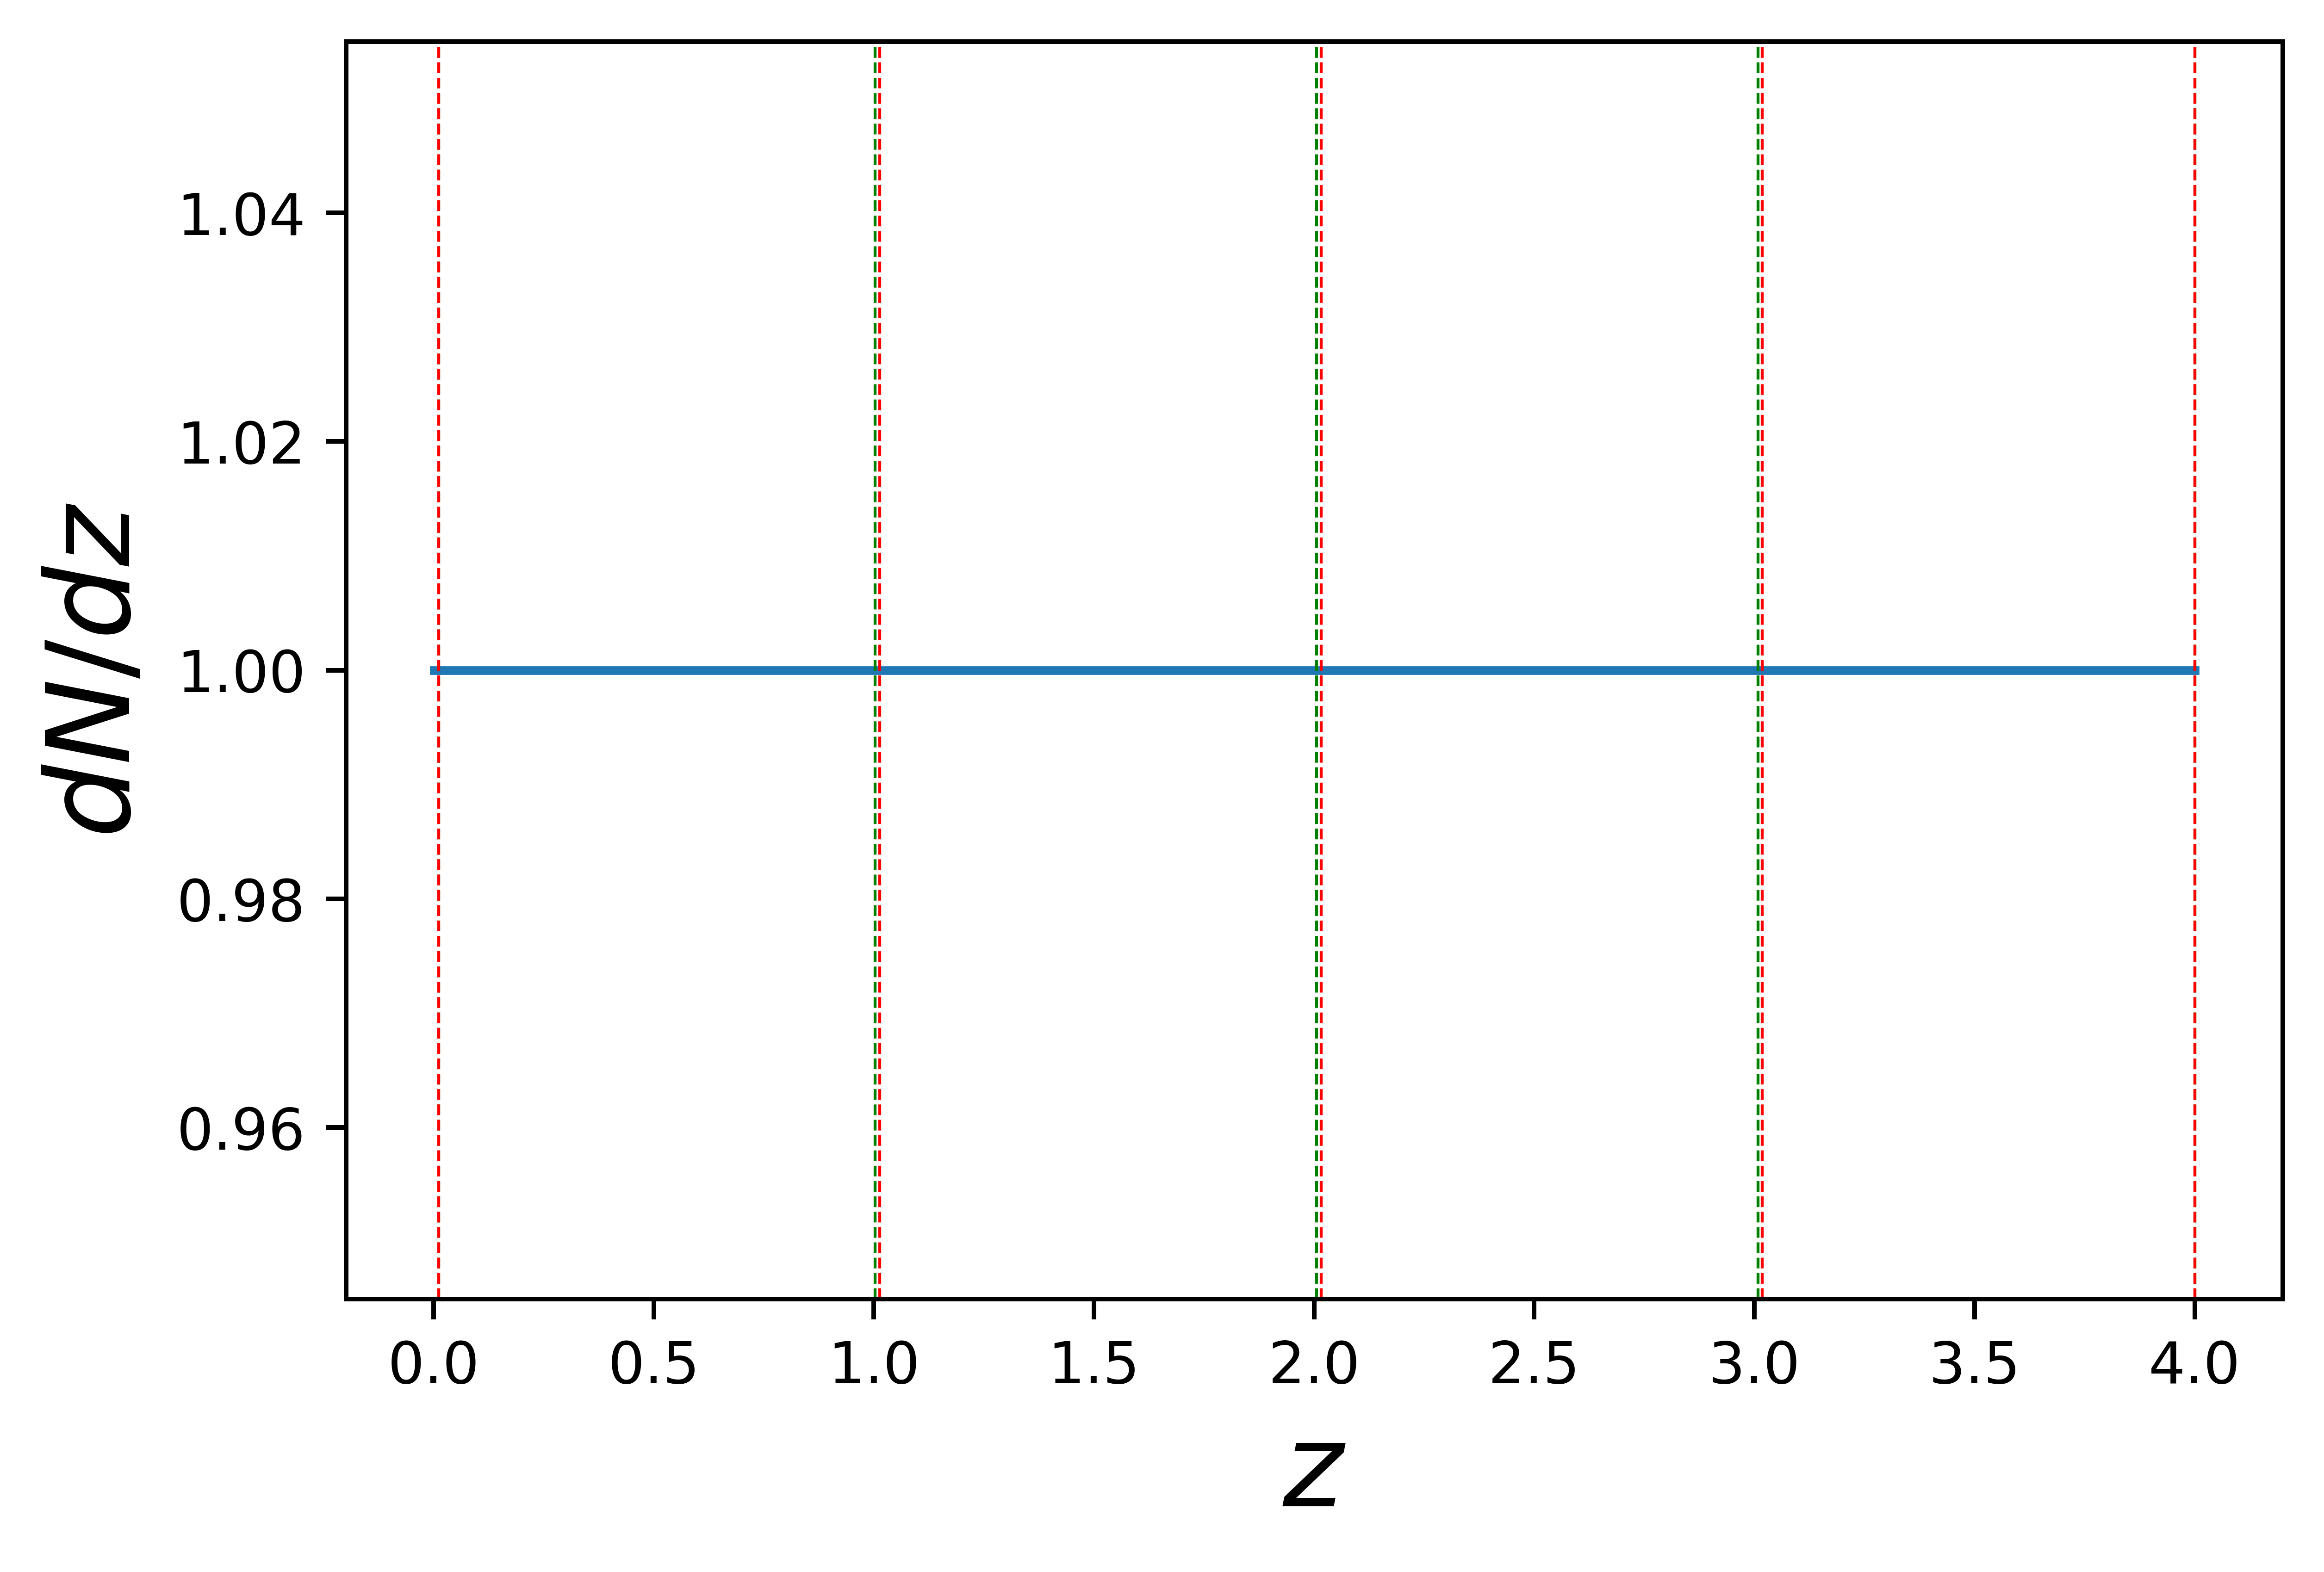

In [37]:
plt.plot(dndz_f[:,0], dndz_f[:,1])
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$dN/dz$',fontsize=20)
for x in redshifts_f["n_4"]:
    plt.axvline(x, linewidth=0.5, color="g", linestyle="--")
for x in redshifts_f["z_4"]:
    plt.axvline(x, linewidth=0.5, color="r", linestyle="--")
plt.show()

Not sure thwy the two divisions aren't exactly matched

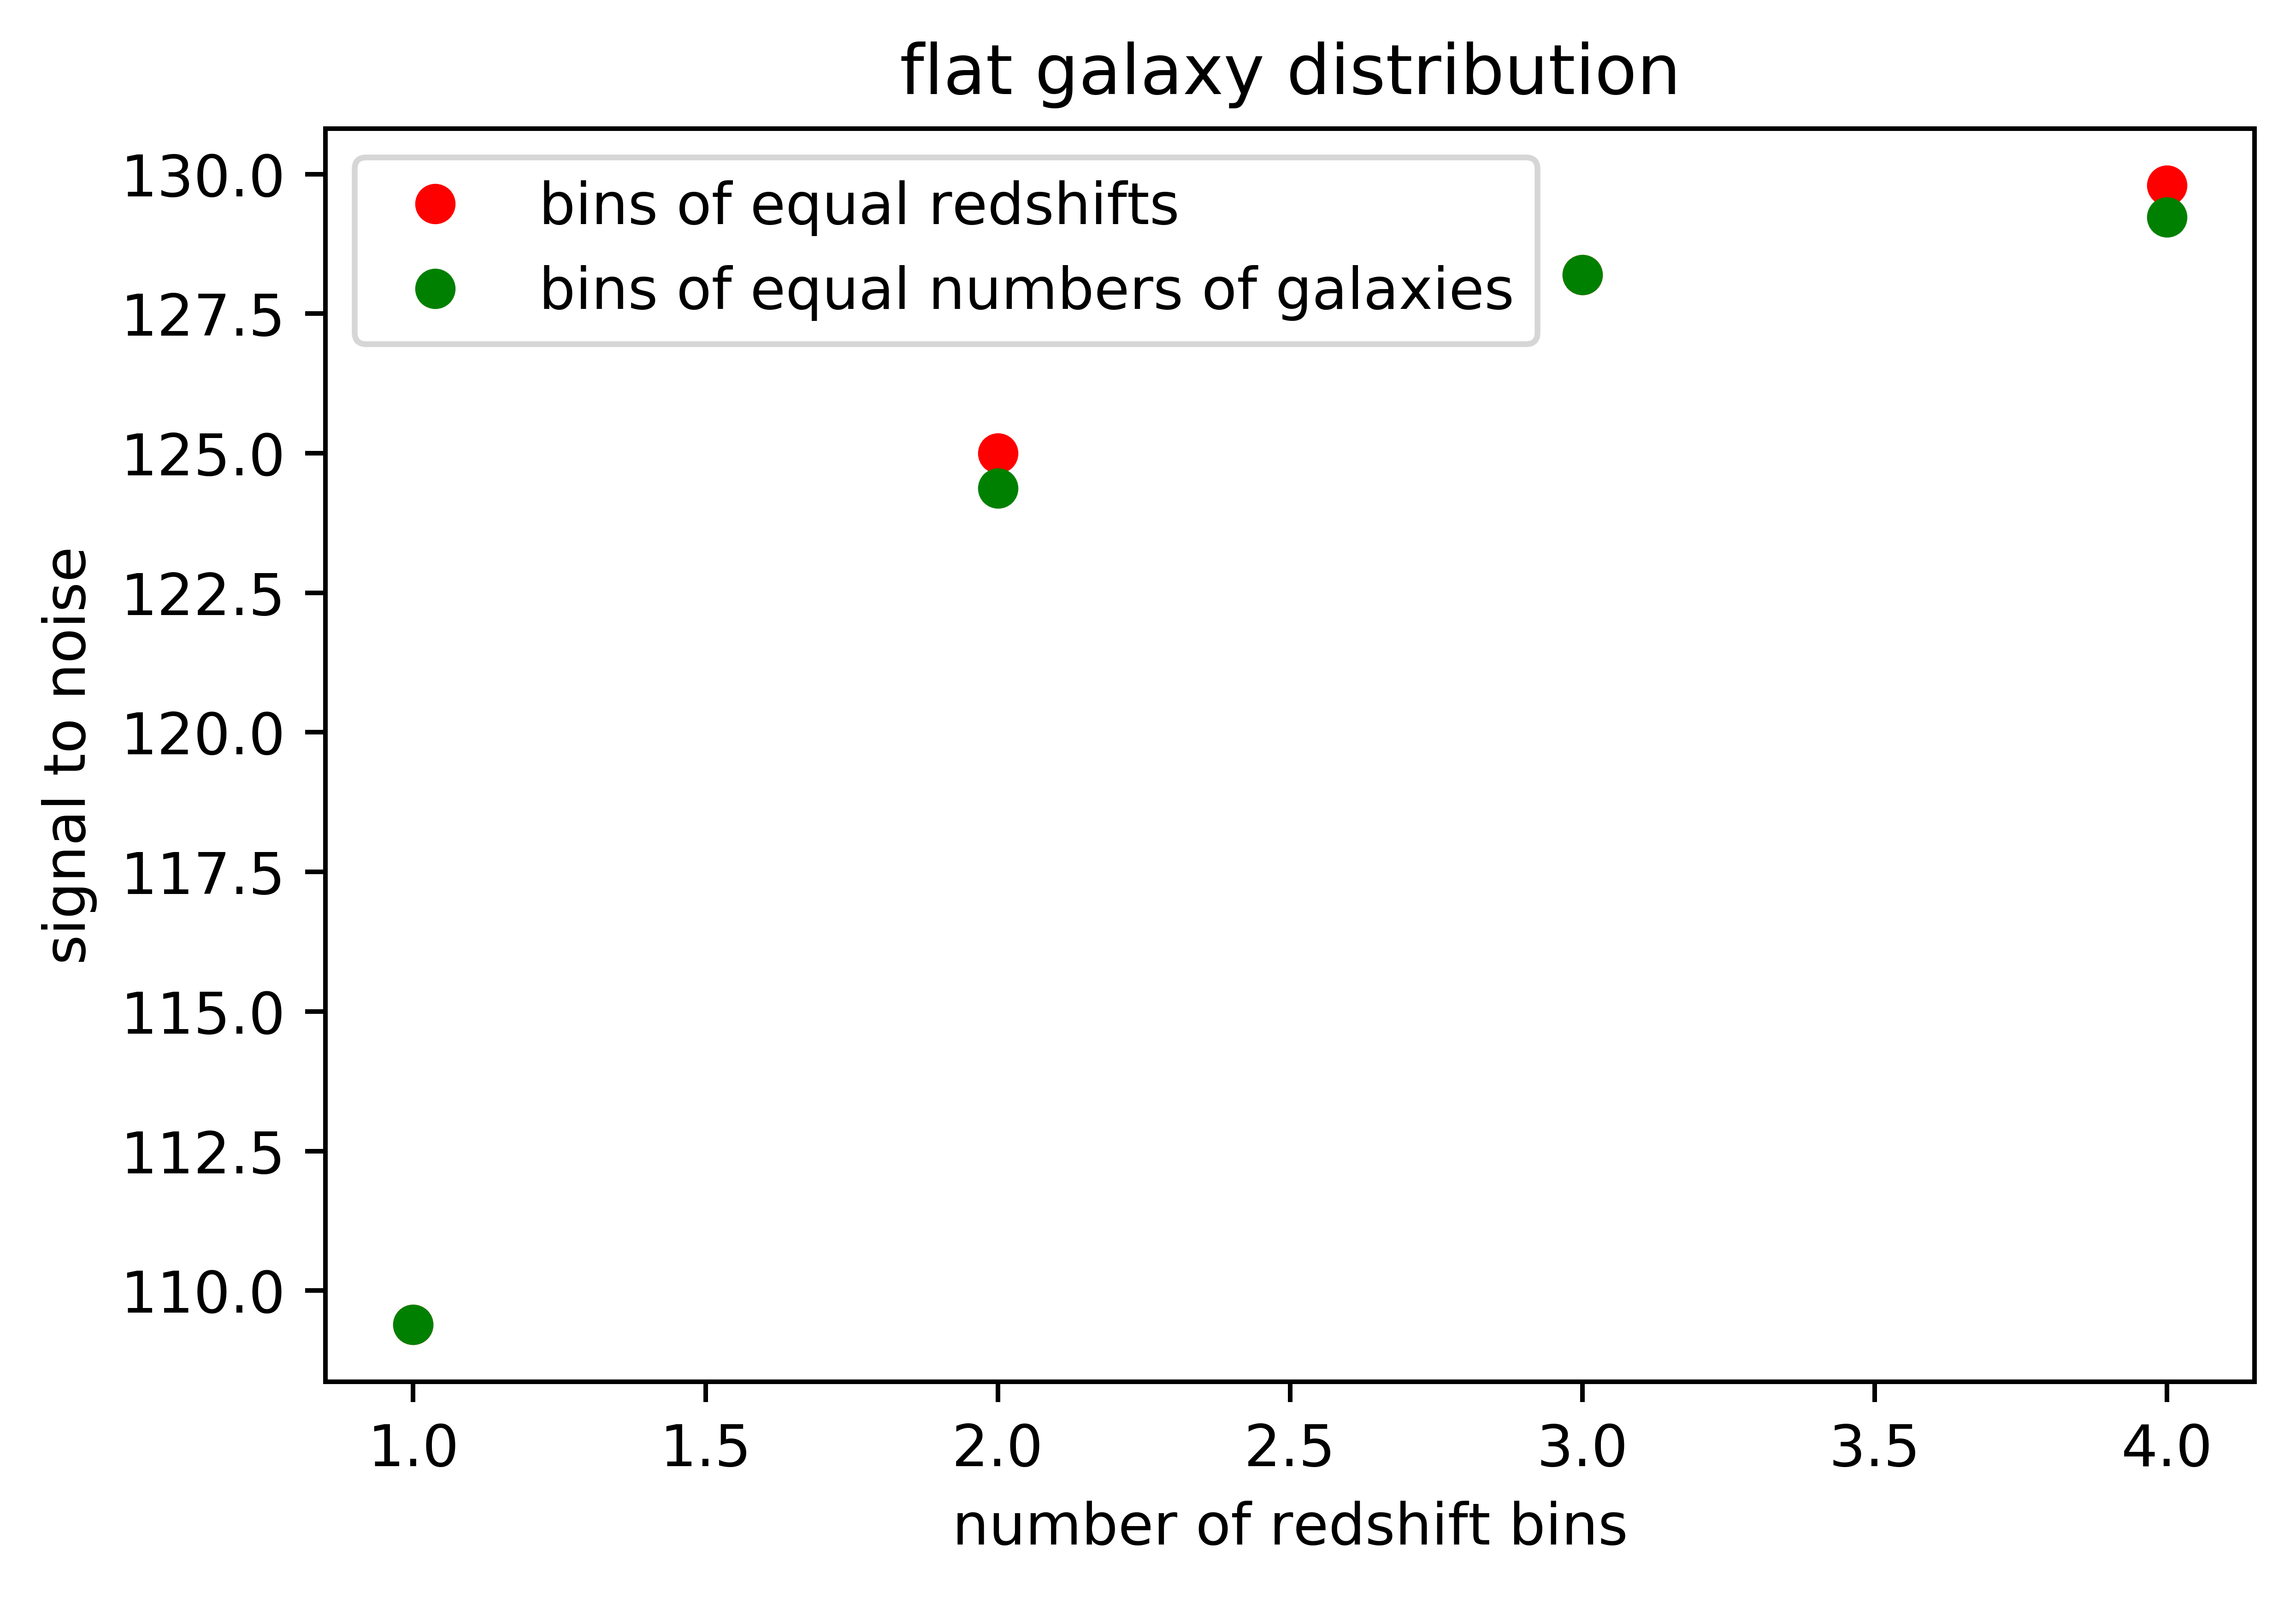

In [38]:
params = {'legend.fontsize': 10,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4], [stn_f["z_1"], stn_f["z_2"], stn_f["z_3"], stn_f["z_4"]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4], [stn_f["n_1"], stn_f["n_2"], stn_f["n_3"], stn_f["n_4"]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("number of redshift bins")
plt.ylabel("signal to noise")
plt.legend(loc="upper left")
plt.title('flat galaxy distribution')
plt.show() 

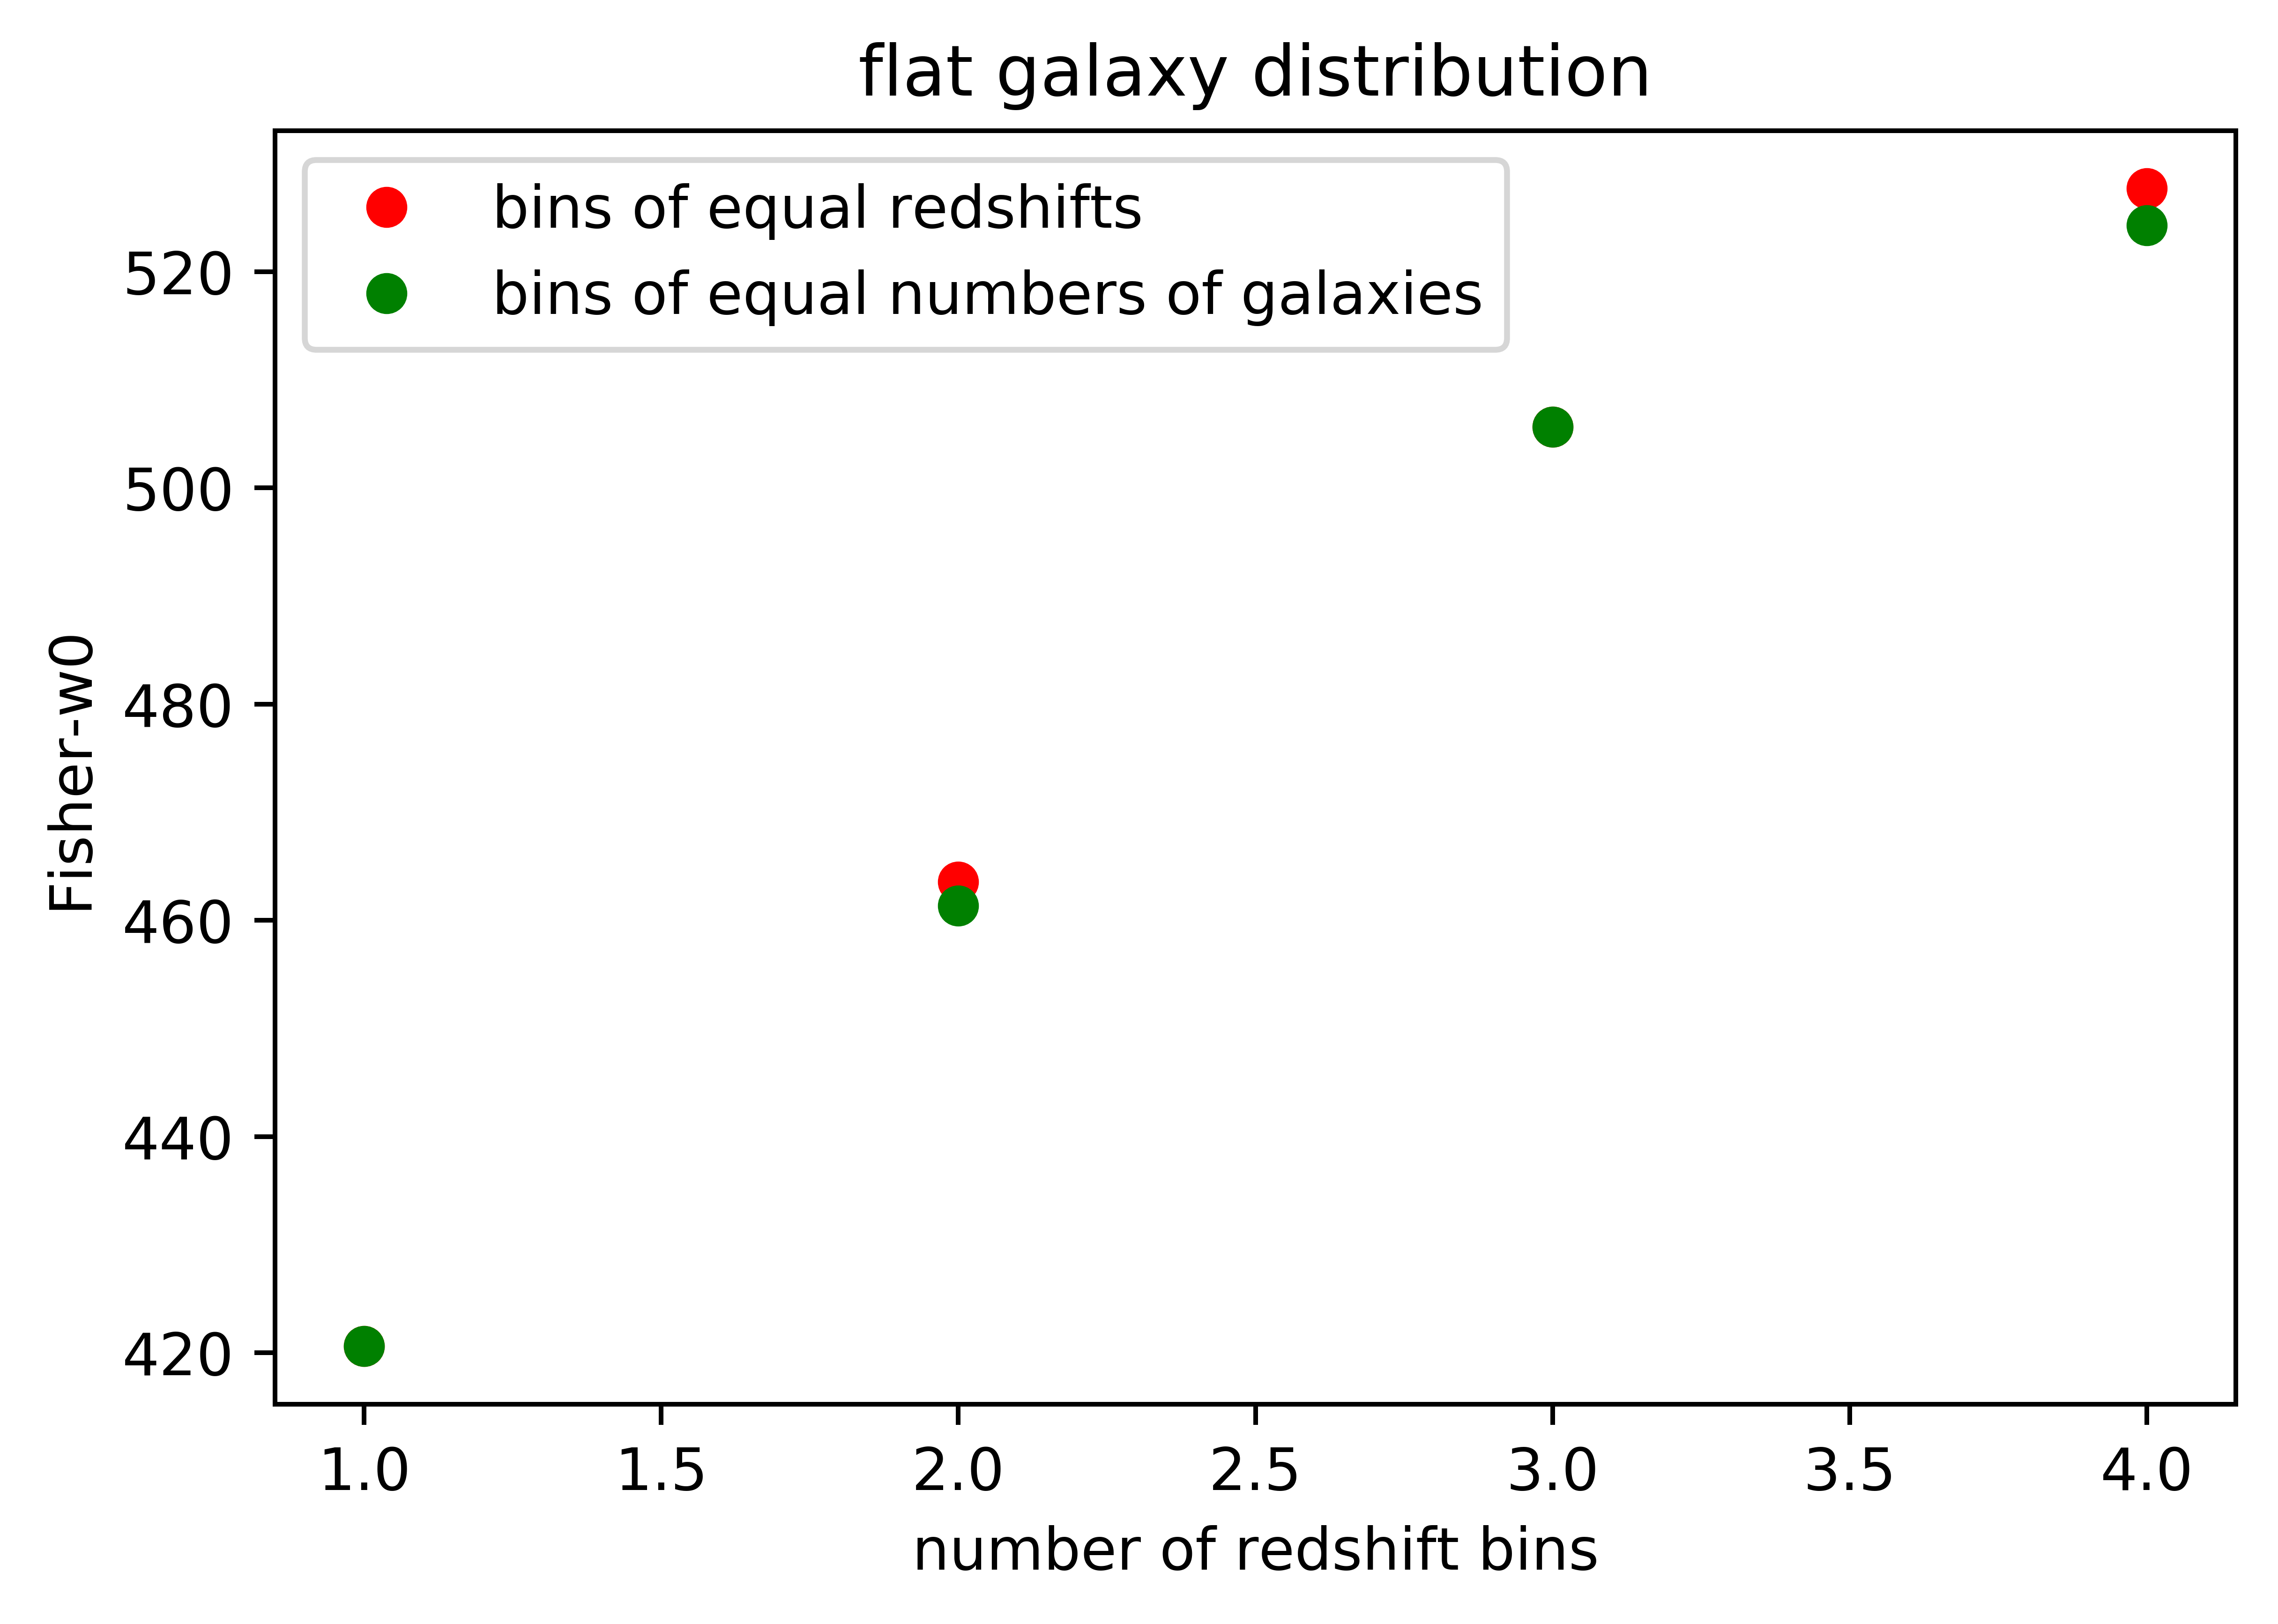

In [39]:
params = {'legend.fontsize': 10,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4], [fisher_f["z_1"][3,3], fisher_f["z_2"][3,3], fisher_f["z_3"][3,3], fisher_f["z_4"][3,3]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4], [fisher_f["n_1"][3,3], fisher_f["n_2"][3,3], fisher_f["n_3"][3,3], fisher_f["n_4"][3,3]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("number of redshift bins")
plt.ylabel("Fisher-w0")
plt.legend(loc="upper left")
plt.title('flat galaxy distribution')
plt.show() 